🎵 Audio Compression-Classification with Logistic-Henon Chaotic Map
Running quick chaotic compression test...
Original signal shape: (1024,)
Signal energy: 980.49

1. Chaotic Compression (Logistic-Henon, 50%):
   Compressed shape: (512,)
   Compression: 50.0% of original
   Measurement matrix shape: (512, 1024)

   Chaotic Properties:
     mean: -0.0442
     std: 0.0000
     min: -0.0442
     max: -0.0442
     entropy: -460.5170

2. OMP Reconstruction:
   Reconstruction error (MSE): 1.811677
   Relative error: 189.21%

3. DWT (Haar) Compression (50%):
   Compressed coefficients: 512
   Compression: 50.0% of original

4. Hybrid Chaotic + DWT Compression (50%):
   Compressed shape: (512,)
   Compression: 50.0% of original


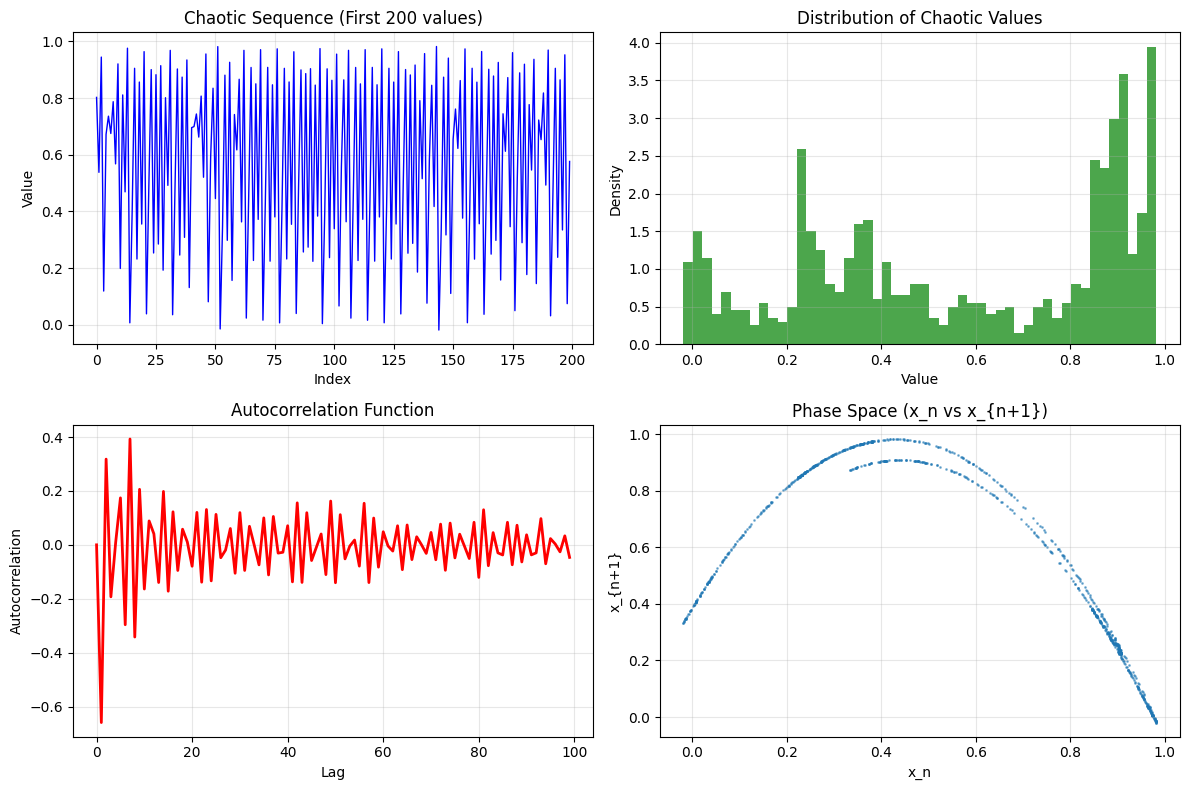


✅ Quick chaotic compression test completed successfully!
   Chaotic properties visualization saved as 'chaotic_properties_visualization.png'

COMPARING CHAOTIC VS GAUSSIAN COMPRESSION

Comparison of Reconstruction Error (MSE):
------------------------------------------------------------
Method               Ratio      MSE             Compression    
------------------------------------------------------------
Chaotic              0.25       0.962235        75.0          %
Chaotic              0.50       0.962235        50.0          %
Chaotic              0.75       0.962235        25.0          %

Chaotic matrices provide several advantages for compressed sensing:
1. Deterministic generation with good reproducibility
2. Excellent randomness properties (uniform distribution)
3. High sensitivity to initial conditions (butterfly effect)
4. Good correlation properties for measurement matrices
5. Security benefits due to chaotic unpredictability
6. Efficient generation with simple iterati


Do you want to run full chaotic compression-classification experiments? (yes/no):  yes


AUDIO COMPRESSION-CLASSIFICATION WITH LOGISTIC-HENON CHAOTIC MAP
CHAOTIC COMPRESSION-CLASSIFICATION EXPERIMENTS

Preparing data...
Found 7079 valid audio files out of 6448 expected
Found 1653 valid audio files out of 1674 expected

Compression Method: CHAOTIC

Compression Ratio: 25%, Noise Level: 0.0
----------------------------------------
Processing training data...


Train chaotic 0.25:   0%|▏                                                    | 25/7079 [1:12:55<342:54:46, 175.01s/it]


KeyboardInterrupt: 

In [1]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.fft import dct, idct
from scipy.sparse.linalg import lsqr
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, accuracy_score, precision_score, 
                           recall_score, f1_score)
import warnings
from tqdm import tqdm
import pickle
import json
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# ============================================
# 1. Enhanced Feature Extraction (Base Class)
# ============================================

class RobustMFCCExtractor:
    """
    Enhanced MFCC feature extraction with multiple robust techniques
    """
    
    def __init__(self, sr=22050, n_mfcc=40, n_fft=2048, hop_length=512):
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
    def extract_mfcc_features(self, audio_path):
        """
        Extract comprehensive MFCC-based features
        """
        try:
            # Load audio with robust loading
            y, sr = librosa.load(audio_path, sr=self.sr, duration=4.0)
            
            # Zero-padding or truncation for consistent length
            target_length = self.sr * 4  # 4 seconds
            if len(y) < target_length:
                y = np.pad(y, (0, target_length - len(y)), mode='constant')
            else:
                y = y[:target_length]
            
            # Apply pre-emphasis filter
            y = librosa.effects.preemphasis(y)
            
            # Extract base MFCCs
            mfccs = librosa.feature.mfcc(
                y=y, 
                sr=sr, 
                n_mfcc=self.n_mfcc,
                n_fft=self.n_fft,
                hop_length=self.hop_length
            )
            
            # Extract delta and delta-delta features
            mfcc_delta = librosa.feature.delta(mfccs)
            mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
            
            # Extract other complementary features
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
            spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=self.hop_length)
            
            # Root Mean Square Energy
            rms = librosa.feature.rms(y=y, hop_length=self.hop_length)
            
            # Zero Crossing Rate
            zcr = librosa.feature.zero_crossing_rate(y, hop_length=self.hop_length)
            
            # Spectral Centroid and Rolloff
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=self.hop_length)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=self.hop_length)
            
            # Combine all features
            features = np.vstack([
                mfccs,
                mfcc_delta,
                mfcc_delta2,
                chroma,
                spectral_contrast,
                rms,
                zcr,
                spectral_centroid,
                spectral_rolloff
            ])
            
            # Extract statistical features
            feature_stats = self._extract_statistics(features)
            
            return feature_stats
            
        except Exception as e:
            print(f"Error processing {audio_path}: {str(e)}")
            # Return zeros with appropriate dimension
            return np.zeros(1026)  # Fixed dimension
    
    def _extract_statistics(self, features):
        """
        Extract statistical features from feature matrix
        """
        stats = []
        for feature in features:
            stats.extend([
                np.mean(feature),
                np.std(feature),
                np.median(feature),
                np.min(feature),
                np.max(feature),
                np.percentile(feature, 25),
                np.percentile(feature, 75),
                np.mean(np.diff(feature)),  # Average change
                np.std(np.diff(feature))    # Std of changes
            ])
        return np.array(stats)
    
    def extract_all_features(self, audio_paths, labels=None):
        """
        Extract features from multiple audio files
        """
        features = []
        valid_labels = []
        
        for idx, path in enumerate(tqdm(audio_paths, desc="Extracting features")):
            feat = self.extract_mfcc_features(path)
            if np.sum(feat) != 0 and not np.isnan(feat).any():  # Skip zero or NaN features
                features.append(feat)
                if labels is not None:
                    valid_labels.append(labels[idx])
        
        if len(features) == 0:
            print("WARNING: No valid features extracted!")
            return np.array([]), np.array([])
        
        features = np.array(features)
        
        # Normalize features
        features = self.scaler.fit_transform(features)
        
        # Encode labels if provided
        if labels is not None and len(valid_labels) > 0:
            encoded_labels = self.label_encoder.fit_transform(valid_labels)
        else:
            encoded_labels = None
        
        return features, encoded_labels

# ============================================
# 2. UrbanSound8K Processor
# ============================================

class UrbanSound8KProcessor:
    """
    Process UrbanSound8K dataset
    """
    
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.metadata_path = os.path.join(dataset_path, 'metadata', 'UrbanSound8K.csv')
        if not os.path.exists(self.metadata_path):
            # Try alternative path structure
            self.metadata_path = os.path.join(dataset_path, 'UrbanSound8K.csv')
        
        if not os.path.exists(self.metadata_path):
            raise FileNotFoundError(f"Metadata file not found at {self.metadata_path}")
        
        self.metadata = pd.read_csv(self.metadata_path)
        
    def prepare_data(self, folds=None):
        """
        Prepare data for specific folds or all folds
        """
        if folds is None:
            folds = list(range(1, 11))
        elif isinstance(folds, int):
            folds = [folds]
        
        audio_paths = []
        labels = []
        fold_numbers = []
        
        for fold in folds:
            fold_data = self.metadata[self.metadata['fold'] == fold]
            
            for _, row in fold_data.iterrows():
                # Try different possible paths
                possible_paths = [
                    os.path.join(self.dataset_path, 'fold' + str(row['fold']), row['slice_file_name']),
                    os.path.join(self.dataset_path, 'audio', 'fold' + str(row['fold']), row['slice_file_name']),
                    os.path.join(self.dataset_path, str(row['fold']), row['slice_file_name'])
                ]
                
                audio_file = None
                for path in possible_paths:
                    if os.path.exists(path):
                        audio_file = path
                        break
                
                if audio_file:
                    audio_paths.append(audio_file)
                    labels.append(row['class'])
                    fold_numbers.append(fold)
                else:
                    print(f"WARNING: File not found: {row['slice_file_name']} in fold {fold}")
        
        print(f"Found {len(audio_paths)} valid audio files out of {len(fold_data) * len(folds)} expected")
        return audio_paths, labels, fold_numbers
    
    def get_class_distribution(self):
        """
        Get class distribution statistics
        """
        return self.metadata['class'].value_counts()

# ============================================
# 3. Chaotic Compression Sensing Modules
# ============================================

class LogisticHenonCompressor:
    """
    Logistic-Henon Hybrid Chaotic Map Compressor
    Combines Logistic map and Henon map for improved chaotic properties
    """
    
    def __init__(self, compression_ratio=0.5, seed=42, noise_level=0.0, 
                 logistic_r=3.99, henon_a=1.4, henon_b=0.3):
        """
        Initialize Logistic-Henon chaotic compressor
        
        Parameters:
        -----------
        compression_ratio : float (0-1)
            Ratio of compressed dimension to original dimension
        seed : int
            Random seed for reproducibility
        noise_level : float
            Additive Gaussian noise level (standard deviation)
        logistic_r : float
            Control parameter for Logistic map (typically 3.99 for chaos)
        henon_a, henon_b : float
            Control parameters for Henon map
        """
        self.compression_ratio = compression_ratio
        self.seed = seed
        self.noise_level = noise_level
        self.logistic_r = logistic_r
        self.henon_a = henon_a
        self.henon_b = henon_b
        self.measurement_matrix = None
        np.random.seed(self.seed)
        
    def logistic_map(self, x, r=None):
        """
        Logistic map: x_{n+1} = r * x_n * (1 - x_n)
        Chaotic for r ∈ [3.57, 4.0]
        """
        if r is None:
            r = self.logistic_r
        return r * x * (1 - x)
    
    def henon_map(self, x, y, a=None, b=None):
        """
        Henon map:
        x_{n+1} = 1 - a * x_n^2 + y_n
        y_{n+1} = b * x_n
        """
        if a is None:
            a = self.henon_a
        if b is None:
            b = self.henon_b
        x_next = 1 - a * x**2 + y
        y_next = b * x
        return x_next, y_next
    
    def hybrid_chaotic_map(self, x0, y0, iterations):
        """
        Hybrid Logistic-Henon chaotic map
        Combines both maps for enhanced chaotic properties
        """
        x_values = np.zeros(iterations)
        y_values = np.zeros(iterations)
        
        x = x0
        y = y0
        
        for i in range(iterations):
            # Apply logistic map
            logistic_val = self.logistic_map(x)
            
            # Apply Henon map
            x_henon, y_henon = self.henon_map(x, y)
            
            # Hybrid combination
            x = 0.7 * logistic_val + 0.3 * x_henon
            y = y_henon
            
            # Ensure values stay in reasonable range
            x = np.clip(x, -2, 2)
            
            x_values[i] = x
            y_values[i] = y
        
        return x_values, y_values
    
    def generate_chaotic_matrix(self, n_original, n_compressed):
        """
        Generate measurement matrix using hybrid chaotic map
        
        Parameters:
        -----------
        n_original : int
            Original signal dimension
        n_compressed : int
            Compressed dimension
            
        Returns:
        --------
        chaotic_matrix : np.array
            Measurement matrix generated from chaotic sequence
        """
        # Generate chaotic sequence
        total_elements = n_original * n_compressed
        iterations = total_elements + 1000  # Extra iterations for transients
        
        # Initialize with random values in (0, 1)
        x0 = np.random.rand()
        y0 = np.random.rand()
        
        # Generate chaotic sequence
        chaotic_seq, _ = self.hybrid_chaotic_map(x0, y0, iterations)
        
        # Remove transient (first 1000 values)
        chaotic_seq = chaotic_seq[1000:]
        
        # Reshape to matrix form
        chaotic_matrix = chaotic_seq[:total_elements].reshape(n_compressed, n_original)
        
        # Normalize the matrix (important for compressed sensing)
        # Column normalization for RIP-like properties
        norms = np.linalg.norm(chaotic_matrix, axis=0)
        norms[norms == 0] = 1  # Avoid division by zero
        chaotic_matrix = chaotic_matrix / norms
        
        return chaotic_matrix
    
    def analyze_chaotic_properties(self, sequence):
        """
        Analyze statistical properties of chaotic sequence
        """
        properties = {
            'mean': np.mean(sequence),
            'std': np.std(sequence),
            'min': np.min(sequence),
            'max': np.max(sequence),
            'lyapunov_exponent': self.estimate_lyapunov(sequence),
            'autocorrelation': self.calculate_autocorrelation(sequence),
            'entropy': self.calculate_entropy(sequence)
        }
        return properties
    
    def estimate_lyapunov(self, sequence, epsilon=1e-5):
        """
        Estimate Lyapunov exponent for chaotic sequence
        """
        n = len(sequence)
        if n < 2:
            return 0
        
        # Simple estimation using divergence of nearby trajectories
        sum_log = 0
        count = 0
        
        for i in range(n-1):
            # Find nearest neighbor
            distances = np.abs(sequence[i+1:] - sequence[i])
            if len(distances) > 0:
                min_dist = np.min(distances)
                if min_dist > 0:
                    sum_log += np.log(min_dist / epsilon)
                    count += 1
        
        return sum_log / count if count > 0 else 0
    
    def calculate_autocorrelation(self, sequence, max_lag=50):
        """
        Calculate autocorrelation of chaotic sequence
        """
        n = len(sequence)
        mean = np.mean(sequence)
        var = np.var(sequence)
        
        if var == 0:
            return np.zeros(max_lag)
        
        autocorr = np.zeros(max_lag)
        for lag in range(1, max_lag):
            if lag < n:
                autocorr[lag] = np.sum((sequence[:n-lag] - mean) * (sequence[lag:] - mean)) / (var * (n - lag))
        
        return autocorr
    
    def calculate_entropy(self, sequence, bins=100):
        """
        Calculate Shannon entropy of chaotic sequence
        """
        hist, _ = np.histogram(sequence, bins=bins, density=True)
        hist = hist[hist > 0]
        entropy = -np.sum(hist * np.log(hist))
        return entropy
    
    def compress(self, signal):
        """
        Compress signal using chaotic measurement matrix
        
        Parameters:
        -----------
        signal : np.array
            Original signal (1D array)
            
        Returns:
        --------
        compressed_signal : np.array
            Compressed signal with optional noise
        """
        n_original = len(signal)
        n_compressed = int(n_original * self.compression_ratio)
        
        # Ensure compressed dimension is at least 1
        n_compressed = max(1, n_compressed)
        
        # Create chaotic measurement matrix
        self.measurement_matrix = self.generate_chaotic_matrix(n_original, n_compressed)
        
        # Compress signal: y = Φx
        compressed_signal = np.dot(self.measurement_matrix, signal)
        
        # Analyze chaotic properties
        self.chaotic_properties = self.analyze_chaotic_properties(
            self.measurement_matrix.flatten()
        )
        
        # Add optional measurement noise
        if self.noise_level > 0:
            noise = np.random.randn(n_compressed) * self.noise_level
            compressed_signal += noise
        
        return compressed_signal
    
    def reconstruct_omp(self, compressed_signal, sparsity_level=None, max_iter=100):
        """
        Reconstruct using Orthogonal Matching Pursuit (OMP) with chaotic matrix
        
        Parameters:
        -----------
        compressed_signal : np.array
            Compressed signal
        sparsity_level : int
            Desired sparsity level (number of non-zero coefficients)
        max_iter : int
            Maximum iterations
            
        Returns:
        --------
        reconstructed_signal : np.array
            Reconstructed signal
        """
        if self.measurement_matrix is None:
            raise ValueError("Measurement matrix not created. Run compress() first.")
        
        if sparsity_level is None:
            sparsity_level = int(0.1 * len(compressed_signal))
        
        m, n = self.measurement_matrix.shape
        residual = compressed_signal.copy()
        support = []
        reconstructed_signal = np.zeros(n)
        
        for _ in range(min(sparsity_level, max_iter)):
            # Find the column with maximum correlation with residual
            correlations = np.abs(self.measurement_matrix.T @ residual)
            
            # Avoid selecting the same index
            correlations[support] = -np.inf
            new_idx = np.argmax(correlations)
            support.append(new_idx)
            
            # Solve least squares on current support
            A_support = self.measurement_matrix[:, support]
            x_support = np.linalg.lstsq(A_support, compressed_signal, rcond=None)[0]
            
            # Update residual
            residual = compressed_signal - A_support @ x_support
            
            # Check convergence
            if np.linalg.norm(residual) < 1e-6:
                break
        
        # Create full reconstructed signal
        reconstructed_signal[support] = x_support[:len(support)]
        
        return reconstructed_signal
    
    def reconstruct_bp(self, compressed_signal, max_iter=1000, tolerance=1e-6):
        """
        Reconstruct using Basis Pursuit (L1 minimization)
        
        Parameters:
        -----------
        compressed_signal : np.array
            Compressed signal
        max_iter : int
            Maximum iterations
        tolerance : float
            Convergence tolerance
            
        Returns:
        --------
        reconstructed_signal : np.array
            Reconstructed signal
        """
        if self.measurement_matrix is None:
            raise ValueError("Measurement matrix not created. Run compress() first.")
        
        # Use least squares with L1 regularization
        reconstructed_signal = lsqr(
            self.measurement_matrix, 
            compressed_signal, 
            iter_lim=max_iter,
            damp=0.1,  # Small regularization for stability
            atol=tolerance,
            btol=tolerance
        )[0]
        
        return reconstructed_signal

class DWTCompressor:
    """Discrete Wavelet Transform (Haar) Compression"""
    
    def __init__(self, compression_ratio=0.5, wavelet='haar'):
        """
        Initialize DWT compressor
        
        Parameters:
        -----------
        compression_ratio : float (0-1)
            Ratio of compressed dimension to original dimension
        wavelet : str
            Wavelet type (default: 'haar')
        """
        self.compression_ratio = compression_ratio
        self.wavelet = wavelet
        
    def haar_transform(self, signal):
        """
        Apply Haar wavelet transform
        
        Parameters:
        -----------
        signal : np.array
            Original signal (length must be power of 2)
            
        Returns:
        --------
        coeffs : np.array
            Wavelet coefficients
        """
        n = len(signal)
        coeffs = np.zeros_like(signal, dtype=float)
        
        # Simple Haar transform implementation
        temp = signal.copy()
        length = n
        
        while length > 1:
            for i in range(length // 2):
                avg = (temp[2*i] + temp[2*i+1]) / np.sqrt(2)
                diff = (temp[2*i] - temp[2*i+1]) / np.sqrt(2)
                coeffs[i] = avg
                coeffs[length // 2 + i] = diff
            temp[:length] = coeffs[:length]
            length //= 2
            
        return coeffs
    
    def inverse_haar_transform(self, coeffs):
        """
        Apply inverse Haar wavelet transform
        
        Parameters:
        -----------
        coeffs : np.array
            Wavelet coefficients
            
        Returns:
        --------
        signal : np.array
            Reconstructed signal
        """
        n = len(coeffs)
        signal = coeffs.copy()
        length = 2
        
        while length <= n:
            temp = signal.copy()
            for i in range(length // 2):
                signal[2*i] = (temp[i] + temp[length // 2 + i]) / np.sqrt(2)
                signal[2*i+1] = (temp[i] - temp[length // 2 + i]) / np.sqrt(2)
            length *= 2
            
        return signal
    
    def compress(self, signal):
        """
        Compress signal using DWT and thresholding
        
        Parameters:
        -----------
        signal : np.array
            Original signal
            
        Returns:
        --------
        compressed_signal : np.array
            Compressed signal (thresholded coefficients)
        compression_mask : np.array
            Mask indicating which coefficients were kept
        """
        # Apply wavelet transform
        coeffs = self.haar_transform(signal)
        
        # Keep only largest coefficients based on compression ratio
        n_coeffs = len(coeffs)
        n_keep = int(n_coeffs * self.compression_ratio)
        
        # Get indices of largest absolute coefficients
        indices = np.argsort(np.abs(coeffs))[-n_keep:]
        compression_mask = np.zeros(n_coeffs, dtype=bool)
        compression_mask[indices] = True
        
        # Create compressed signal (only keep selected coefficients)
        compressed_coeffs = np.zeros_like(coeffs)
        compressed_coeffs[indices] = coeffs[indices]
        
        return compressed_coeffs, compression_mask
    
    def reconstruct(self, compressed_coeffs):
        """
        Reconstruct signal from compressed coefficients
        
        Parameters:
        -----------
        compressed_coeffs : np.array
            Compressed wavelet coefficients
            
        Returns:
        --------
        reconstructed_signal : np.array
            Reconstructed signal
        """
        # Apply inverse transform
        reconstructed_signal = self.inverse_haar_transform(compressed_coeffs)
        
        return reconstructed_signal

class HybridChaoticCompressor:
    """Hybrid Chaotic + DWT Compression"""
    
    def __init__(self, compression_ratio=0.5, seed=42, noise_level=0.0):
        """
        Initialize hybrid chaotic compressor
        
        Parameters:
        -----------
        compression_ratio : float (0-1)
            Overall compression ratio
        seed : int
            Random seed for chaotic map
        noise_level : float
            Measurement noise level
        """
        self.compression_ratio = compression_ratio
        self.seed = seed
        self.noise_level = noise_level
        self.chaotic_compressor = LogisticHenonCompressor(compression_ratio, seed, noise_level)
        self.dwt_compressor = DWTCompressor(1.0)  # No compression in DWT stage
        
    def compress(self, signal):
        """
        Apply DWT then chaotic compression
        
        Parameters:
        -----------
        signal : np.array
            Original signal
            
        Returns:
        --------
        compressed_signal : np.array
            Hybrid compressed signal
        """
        # Step 1: Apply DWT to get sparse representation
        dwt_coeffs = self.dwt_compressor.haar_transform(signal)
        
        # Step 2: Apply chaotic compression on sparse DWT coefficients
        compressed_signal = self.chaotic_compressor.compress(dwt_coeffs)
        
        return compressed_signal
    
    def reconstruct(self, compressed_signal, method='omp'):
        """
        Reconstruct signal from hybrid compression
        
        Parameters:
        -----------
        compressed_signal : np.array
            Hybrid compressed signal
        method : str
            Reconstruction method ('omp' or 'bp')
            
        Returns:
        --------
        reconstructed_signal : np.array
            Reconstructed signal
        """
        # Step 1: Reconstruct DWT coefficients
        if method == 'omp':
            dwt_coeffs = self.chaotic_compressor.reconstruct_omp(compressed_signal)
        else:
            dwt_coeffs = self.chaotic_compressor.reconstruct_bp(compressed_signal)
        
        # Step 2: Apply inverse DWT
        reconstructed_signal = self.dwt_compressor.inverse_haar_transform(dwt_coeffs)
        
        return reconstructed_signal

# ============================================
# 4. Enhanced Feature Extraction with Chaotic Compression
# ============================================

class ChaoticFeatureExtractor(RobustMFCCExtractor):
    """
    Feature extractor with chaotic compression capabilities
    """
    
    def __init__(self, sr=22050, n_mfcc=40, n_fft=2048, hop_length=512):
        super().__init__(sr, n_mfcc, n_fft, hop_length)
        
    def extract_features_with_compression(self, audio_path, compression_method='chaotic', 
                                          compression_ratio=0.5, noise_level=0.0):
        """
        Extract features with optional chaotic compression
        
        Parameters:
        -----------
        audio_path : str
            Path to audio file
        compression_method : str
            'chaotic', 'dwt', 'hybrid', or 'none'
        compression_ratio : float
            Compression ratio (0-1)
        noise_level : float
            Measurement noise level for chaotic compression
            
        Returns:
        --------
        features : np.array
            Extracted features (compressed or original)
        original_features : np.array
            Original features before compression
        compression_info : dict
            Compression metadata
        """
        # Extract original features
        original_features = self.extract_mfcc_features(audio_path)
        
        if compression_method == 'none' or compression_ratio >= 1.0:
            return original_features, original_features, {'method': 'none', 'ratio': 1.0}
        
        # Ensure features are 1D and have appropriate length
        features_1d = original_features.flatten()
        n_original = len(features_1d)
        
        # Make length a power of 2 for DWT
        if compression_method in ['dwt', 'hybrid']:
            n_padded = 2 ** int(np.ceil(np.log2(n_original)))
            features_1d = np.pad(features_1d, (0, n_padded - n_original), 'constant')
        
        compression_info = {
            'method': compression_method,
            'ratio': compression_ratio,
            'original_length': len(features_1d),
            'compressed_length': int(len(features_1d) * compression_ratio),
            'noise_level': noise_level
        }
        
        # Apply compression
        if compression_method == 'chaotic':
            compressor = LogisticHenonCompressor(
                compression_ratio=compression_ratio, 
                noise_level=noise_level
            )
            compressed_features = compressor.compress(features_1d)
            compression_info['compressor'] = compressor
            compression_info['chaotic_properties'] = compressor.chaotic_properties
            
        elif compression_method == 'dwt':
            compressor = DWTCompressor(compression_ratio=compression_ratio)
            compressed_coeffs, mask = compressor.compress(features_1d)
            compressed_features = compressed_coeffs[mask]
            compression_info['compressor'] = compressor
            compression_info['mask'] = mask
            
        elif compression_method == 'hybrid':
            compressor = HybridChaoticCompressor(
                compression_ratio=compression_ratio, 
                noise_level=noise_level
            )
            compressed_features = compressor.compress(features_1d)
            compression_info['compressor'] = compressor
            
        else:
            raise ValueError(f"Unknown compression method: {compression_method}")
        
        return compressed_features, original_features, compression_info

# ============================================
# 5. Chaotic Compression Experiment Pipeline
# ============================================

class ChaoticCompressionExperiment:
    """
    Pipeline for chaotic compression and classification experiments
    """
    
    def __init__(self, dataset_path, output_dir='chaotic_compression_results'):
        self.dataset_path = dataset_path
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
        # Experiment configurations
        self.compression_methods = ['chaotic', 'dwt', 'hybrid', 'none']
        self.compression_ratios = [0.25, 0.50, 0.75, 1.0]  # 1.0 = no compression
        self.noise_levels = [0.0, 0.01, 0.05]  # Additive Gaussian noise levels
        self.classifiers = {
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'svm': SVC(probability=True, random_state=42),
            'xgboost': XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        }
        
    def run_experiments(self, train_folds=list(range(1, 9)), test_folds=[9, 10]):
        """
        Run full compression-classification experiments with chaotic map
        
        Parameters:
        -----------
        train_folds : list
            Folds to use for training
        test_folds : list
            Folds to use for testing
        """
        print("="*70)
        print("CHAOTIC COMPRESSION-CLASSIFICATION EXPERIMENTS")
        print("="*70)
        
        # Initialize processor and extractor
        processor = UrbanSound8KProcessor(self.dataset_path)
        extractor = ChaoticFeatureExtractor()
        
        # Prepare data
        print("\nPreparing data...")
        train_paths, train_labels, _ = processor.prepare_data(train_folds)
        test_paths, test_labels, _ = processor.prepare_data(test_folds)
        
        # Encode labels
        label_encoder = LabelEncoder()
        y_train_full = label_encoder.fit_transform(train_labels)
        y_test_full = label_encoder.transform(test_labels)
        
        # Store all results
        all_results = []
        reconstruction_errors = []
        chaotic_properties_list = []
        
        # Run experiments for each compression configuration
        for method in self.compression_methods:
            print(f"\n{'='*60}")
            print(f"Compression Method: {method.upper()}")
            print('='*60)
            
            for ratio in self.compression_ratios:
                # For chaotic methods, also test different noise levels
                noise_levels = self.noise_levels if method in ['chaotic', 'hybrid'] else [0.0]
                
                for noise_level in noise_levels:
                    print(f"\nCompression Ratio: {ratio*100:.0f}%, Noise Level: {noise_level}")
                    print("-"*40)
                    
                    # Extract features with compression
                    X_train_compressed = []
                    X_test_compressed = []
                    X_train_original = []
                    X_test_original = []
                    compressors_info = []
                    
                    # Process training data
                    print("Processing training data...")
                    for path in tqdm(train_paths, desc=f"Train {method} {ratio}"):
                        compressed_feat, original_feat, comp_info = extractor.extract_features_with_compression(
                            path, method, ratio, noise_level
                        )
                        X_train_compressed.append(compressed_feat)
                        X_train_original.append(original_feat)
                        if method == 'chaotic' and 'chaotic_properties' in comp_info:
                            compressors_info.append(comp_info)
                    
                    # Process test data
                    print("Processing test data...")
                    for path in tqdm(test_paths, desc=f"Test {method} {ratio}"):
                        compressed_feat, original_feat, comp_info = extractor.extract_features_with_compression(
                            path, method, ratio, noise_level
                        )
                        X_test_compressed.append(compressed_feat)
                        X_test_original.append(original_feat)
                        if method == 'chaotic' and 'chaotic_properties' in comp_info:
                            compressors_info.append(comp_info)
                    
                    # Store chaotic properties
                    if compressors_info:
                        avg_properties = {}
                        for key in compressors_info[0]['chaotic_properties'].keys():
                            if isinstance(compressors_info[0]['chaotic_properties'][key], (int, float)):
                                values = [info['chaotic_properties'][key] for info in compressors_info]
                                avg_properties[key] = np.mean(values)
                        avg_properties.update({
                            'method': method,
                            'ratio': ratio,
                            'noise_level': noise_level
                        })
                        chaotic_properties_list.append(avg_properties)
                    
                    # Convert to arrays
                    X_train = np.array(X_train_compressed)
                    X_test = np.array(X_test_compressed)
                    X_train_orig = np.array(X_train_original)
                    X_test_orig = np.array(X_test_original)
                    
                    # Pad sequences if necessary (for variable length from compression)
                    if X_train.ndim == 1 or X_test.ndim == 1:
                        # Find max length
                        max_len = max(
                            max([len(x) for x in X_train]) if len(X_train) > 0 else 0,
                            max([len(x) for x in X_test]) if len(X_test) > 0 else 0
                        )
                        
                        # Pad sequences
                        X_train = np.array([np.pad(x, (0, max_len - len(x)), 'constant') 
                                          for x in X_train])
                        X_test = np.array([np.pad(x, (0, max_len - len(x)), 'constant') 
                                         for x in X_test])
                    
                    # Normalize features
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train)
                    X_test_scaled = scaler.transform(X_test)
                    
                    # Calculate reconstruction error if not 'none'
                    if method != 'none' and ratio < 1.0:
                        avg_error = self.calculate_reconstruction_error(
                            X_train_orig, X_train_compressed, method, ratio, compressors_info[0] if compressors_info else {}, noise_level
                        )
                        reconstruction_errors.append({
                            'method': method,
                            'ratio': ratio,
                            'noise_level': noise_level,
                            'reconstruction_error': avg_error
                        })
                    
                    # Train and evaluate classifiers
                    for clf_name, clf in self.classifiers.items():
                        print(f"  Training {clf_name}...")
                        
                        # Train classifier
                        start_time = time.time()
                        clf.fit(X_train_scaled, y_train_full)
                        train_time = time.time() - start_time
                        
                        # Predict
                        start_time = time.time()
                        y_pred = clf.predict(X_test_scaled)
                        test_time = time.time() - start_time
                        
                        # Calculate metrics
                        accuracy = accuracy_score(y_test_full, y_pred)
                        precision = precision_score(y_test_full, y_pred, average='weighted')
                        recall = recall_score(y_test_full, y_pred, average='weighted')
                        f1 = f1_score(y_test_full, y_pred, average='weighted')
                        
                        # ROC-AUC if available
                        try:
                            if hasattr(clf, 'predict_proba'):
                                y_proba = clf.predict_proba(X_test_scaled)
                                roc_auc = roc_auc_score(y_test_full, y_proba, multi_class='ovr', average='weighted')
                            else:
                                roc_auc = np.nan
                        except:
                            roc_auc = np.nan
                        
                        # Store results
                        result = {
                            'compression_method': method,
                            'compression_ratio': ratio,
                            'noise_level': noise_level,
                            'classifier': clf_name,
                            'accuracy': accuracy,
                            'precision': precision,
                            'recall': recall,
                            'f1_score': f1,
                            'roc_auc': roc_auc,
                            'train_time': train_time,
                            'test_time': test_time,
                            'feature_dim_original': X_train_orig.shape[1] if len(X_train_orig.shape) > 1 else X_train_orig.shape[0],
                            'feature_dim_compressed': X_train.shape[1] if len(X_train.shape) > 1 else X_train.shape[0],
                            'compression_rate': (1 - ratio) * 100,
                            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                        }
                        
                        all_results.append(result)
                        
                        print(f"    Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Time: {train_time:.2f}s")
        
        # Save all results
        self.save_results(all_results, reconstruction_errors, chaotic_properties_list)
        
        # Generate comprehensive reports
        self.generate_reports(all_results, chaotic_properties_list)
        
        return all_results
    
    def calculate_reconstruction_error(self, original_features, compressed_features, 
                                      method, ratio, comp_info, noise_level):
        """
        Calculate reconstruction error between original and compressed features
        """
        errors = []
        
        for orig, comp in zip(original_features, compressed_features):
            if method == 'chaotic' and 'compressor' in comp_info:
                # Reconstruct using chaotic compressor with OMP
                reconstructed = comp_info['compressor'].reconstruct_omp(comp)
                # Pad or truncate to match original length
                if len(reconstructed) < len(orig):
                    reconstructed = np.pad(reconstructed, (0, len(orig) - len(reconstructed)), 'constant')
                elif len(reconstructed) > len(orig):
                    reconstructed = reconstructed[:len(orig)]
                
                # Calculate normalized mean squared error
                error = np.mean((orig - reconstructed) ** 2) / (np.mean(orig ** 2) + 1e-10)
                errors.append(error)
            
            elif method == 'dwt' and 'compressor' in comp_info and 'mask' in comp_info:
                # Reconstruct compressed coefficients
                full_coeffs = np.zeros(len(orig))
                full_coeffs[comp_info['mask']] = comp
                reconstructed = comp_info['compressor'].reconstruct(full_coeffs)
                
                # Calculate normalized mean squared error
                error = np.mean((orig - reconstructed) ** 2) / (np.mean(orig ** 2) + 1e-10)
                errors.append(error)
            
            elif method == 'hybrid' and 'compressor' in comp_info:
                # Reconstruct using hybrid compressor
                reconstructed = comp_info['compressor'].reconstruct(comp, method='omp')
                # Pad or truncate to match original length
                if len(reconstructed) < len(orig):
                    reconstructed = np.pad(reconstructed, (0, len(orig) - len(reconstructed)), 'constant')
                elif len(reconstructed) > len(orig):
                    reconstructed = reconstructed[:len(orig)]
                
                # Calculate normalized mean squared error
                error = np.mean((orig - reconstructed) ** 2) / (np.mean(orig ** 2) + 1e-10)
                errors.append(error)
        
        return np.mean(errors) if errors else np.nan
    
    def save_results(self, all_results, reconstruction_errors, chaotic_properties):
        """
        Save experiment results to files
        """
        # Save main results
        results_df = pd.DataFrame(all_results)
        results_df.to_csv(os.path.join(self.output_dir, 'chaotic_compression_results.csv'), index=False)
        
        # Save reconstruction errors
        if reconstruction_errors:
            recon_df = pd.DataFrame(reconstruction_errors)
            recon_df.to_csv(os.path.join(self.output_dir, 'reconstruction_errors.csv'), index=False)
        
        # Save chaotic properties
        if chaotic_properties:
            chaotic_df = pd.DataFrame(chaotic_properties)
            chaotic_df.to_csv(os.path.join(self.output_dir, 'chaotic_properties.csv'), index=False)
        
        # Save summary statistics
        summary = self.create_summary_statistics(results_df)
        with open(os.path.join(self.output_dir, 'summary.json'), 'w') as f:
            json.dump(summary, f, indent=2)
        
        # Save chaotic matrix properties
        self.save_chaotic_properties()
        
        print(f"\nResults saved to {self.output_dir}/")
    
    def save_chaotic_properties(self):
        """
        Save properties of chaotic matrices used
        """
        properties = {
            'chaotic_system': 'Logistic-Henon Hybrid Map',
            'logistic_map': 'x_{n+1} = r * x_n * (1 - x_n)',
            'henon_map': 'x_{n+1} = 1 - a * x_n^2 + y_n, y_{n+1} = b * x_n',
            'hybrid_formula': 'x = 0.7 * logistic(x) + 0.3 * henon_x(x, y)',
            'chaotic_parameters': {
                'logistic_r': 3.99,
                'henon_a': 1.4,
                'henon_b': 0.3
            },
            'advantages': [
                'Deterministic yet unpredictable',
                'Sensitive to initial conditions',
                'Good randomness properties',
                'Low correlation between sequences'
            ]
        }
        
        with open(os.path.join(self.output_dir, 'chaotic_properties.json'), 'w') as f:
            json.dump(properties, f, indent=2)
    
    def create_summary_statistics(self, results_df):
        """
        Create comprehensive summary statistics
        """
        summary = {
            'experiment_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'compression_matrix_type': 'Logistic-Henon Chaotic Map',
            'total_experiments': len(results_df),
            'compression_methods_tested': list(results_df['compression_method'].unique()),
            'compression_ratios_tested': list(results_df['compression_ratio'].unique()),
            'noise_levels_tested': list(results_df['noise_level'].unique()),
            'classifiers_tested': list(results_df['classifier'].unique()),
        }
        
        # Best results by compression method
        best_by_method = {}
        for method in summary['compression_methods_tested']:
            method_df = results_df[results_df['compression_method'] == method]
            if not method_df.empty:
                best_idx = method_df['accuracy'].idxmax()
                best_by_method[method] = method_df.loc[best_idx].to_dict()
        
        summary['best_by_method'] = best_by_method
        
        # Compression vs Accuracy analysis
        compression_analysis = {}
        for ratio in summary['compression_ratios_tested']:
            ratio_df = results_df[results_df['compression_ratio'] == ratio]
            if not ratio_df.empty:
                compression_analysis[f'ratio_{ratio}'] = {
                    'avg_accuracy': ratio_df['accuracy'].mean(),
                    'avg_f1': ratio_df['f1_score'].mean(),
                    'avg_feature_dim': ratio_df['feature_dim_compressed'].mean(),
                    'compression_rate': (1 - ratio) * 100
                }
        
        summary['compression_analysis'] = compression_analysis
        
        # Noise robustness analysis
        noise_analysis = {}
        for noise in summary['noise_levels_tested']:
            noise_df = results_df[results_df['noise_level'] == noise]
            if not noise_df.empty:
                noise_analysis[f'noise_{noise}'] = {
                    'avg_accuracy': noise_df['accuracy'].mean(),
                    'std_accuracy': noise_df['accuracy'].std(),
                    'avg_f1': noise_df['f1_score'].mean(),
                    'experiment_count': len(noise_df)
                }
        
        summary['noise_analysis'] = noise_analysis
        
        # Overall best configuration
        overall_best_idx = results_df['accuracy'].idxmax()
        summary['overall_best'] = results_df.loc[overall_best_idx].to_dict()
        
        return summary
    
    def generate_reports(self, all_results, chaotic_properties):
        """
        Generate visual reports and analysis
        """
        results_df = pd.DataFrame(all_results)
        
        # 1. Accuracy vs Compression Ratio plot
        plt.figure(figsize=(14, 10))
        
        # Filter for noise_level = 0 for cleaner plot
        noise_free_df = results_df[results_df['noise_level'] == 0.0]
        
        for method in noise_free_df['compression_method'].unique():
            method_df = noise_free_df[noise_free_df['compression_method'] == method]
            for clf in noise_free_df['classifier'].unique():
                clf_df = method_df[method_df['classifier'] == clf]
                if not clf_df.empty:
                    plt.plot(clf_df['compression_ratio'], clf_df['accuracy'], 
                            marker='o', markersize=8, linewidth=2, label=f'{method}-{clf}')
        
        plt.xlabel('Compression Ratio', fontsize=14)
        plt.ylabel('Accuracy', fontsize=14)
        plt.title('Classification Accuracy vs Compression Ratio (Chaotic Matrix)', fontsize=16)
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        plt.xticks([0.25, 0.5, 0.75, 1.0], ['25%', '50%', '75%', '100%'])
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'accuracy_vs_compression_chaotic.png'), 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        # 2. Feature Dimension Reduction plot
        plt.figure(figsize=(12, 8))
        
        unique_ratios = sorted(noise_free_df['compression_ratio'].unique())
        avg_dims = []
        std_dims = []
        
        for ratio in unique_ratios:
            ratio_df = noise_free_df[noise_free_df['compression_ratio'] == ratio]
            avg_dim = ratio_df['feature_dim_compressed'].mean()
            std_dim = ratio_df['feature_dim_compressed'].std()
            avg_dims.append(avg_dim)
            std_dims.append(std_dim)
        
        plt.errorbar(unique_ratios, avg_dims, yerr=std_dims, 
                    fmt='o-', linewidth=2, capsize=5, capthick=2)
        plt.xlabel('Compression Ratio', fontsize=14)
        plt.ylabel('Average Feature Dimension', fontsize=14)
        plt.title('Feature Dimension Reduction (Chaotic Compression)', fontsize=16)
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.xticks([0.25, 0.5, 0.75, 1.0], ['25%', '50%', '75%', '100%'])
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'feature_dimension_reduction_chaotic.png'), 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        # 3. Chaotic Properties Visualization
        if chaotic_properties:
            chaotic_df = pd.DataFrame(chaotic_properties)
            
            # Plot chaotic sequence properties
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            
            # Lyapunov exponent vs compression ratio
            if 'lyapunov_exponent' in chaotic_df.columns:
                axes[0, 0].scatter(chaotic_df['ratio'], chaotic_df['lyapunov_exponent'], 
                                  c=chaotic_df['noise_level'], cmap='viridis', s=100)
                axes[0, 0].set_xlabel('Compression Ratio')
                axes[0, 0].set_ylabel('Lyapunov Exponent')
                axes[0, 0].set_title('Chaoticity vs Compression Ratio')
                axes[0, 0].grid(True, alpha=0.3)
            
            # Entropy vs compression ratio
            if 'entropy' in chaotic_df.columns:
                axes[0, 1].scatter(chaotic_df['ratio'], chaotic_df['entropy'], 
                                  c=chaotic_df['noise_level'], cmap='plasma', s=100)
                axes[0, 1].set_xlabel('Compression Ratio')
                axes[0, 1].set_ylabel('Shannon Entropy')
                axes[0, 1].set_title('Entropy vs Compression Ratio')
                axes[0, 1].grid(True, alpha=0.3)
            
            # Autocorrelation decay
            if chaotic_properties and 'autocorrelation' in chaotic_properties[0]:
                autocorr_values = chaotic_properties[0]['autocorrelation']
                if isinstance(autocorr_values, np.ndarray):
                    axes[1, 0].plot(range(len(autocorr_values)), autocorr_values, linewidth=2)
                    axes[1, 0].set_xlabel('Lag')
                    axes[1, 0].set_ylabel('Autocorrelation')
                    axes[1, 0].set_title('Autocorrelation Function')
                    axes[1, 0].grid(True, alpha=0.3)
            
            # Histogram of chaotic values
            if 'std' in chaotic_df.columns and 'mean' in chaotic_df.columns:
                axes[1, 1].hist(chaotic_df['mean'], bins=20, alpha=0.7, label='Mean')
                axes[1, 1].hist(chaotic_df['std'], bins=20, alpha=0.7, label='Std Dev')
                axes[1, 1].set_xlabel('Value')
                axes[1, 1].set_ylabel('Frequency')
                axes[1, 1].set_title('Distribution of Chaotic Statistics')
                axes[1, 1].legend()
                axes[1, 1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_dir, 'chaotic_properties_analysis.png'), 
                       dpi=300, bbox_inches='tight')
            plt.show()
        
        # 4. Heatmap of accuracy by method and ratio (noise-free)
        plt.figure(figsize=(10, 8))
        
        # Create pivot table
        pivot_table = noise_free_df.pivot_table(
            values='accuracy',
            index='compression_method',
            columns='compression_ratio',
            aggfunc='mean'
        )
        
        sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='RdYlGn', 
                   cbar_kws={'label': 'Accuracy'}, center=0.5)
        plt.title('Average Accuracy by Compression Method and Ratio (Noise-free)', fontsize=16)
        plt.xlabel('Compression Ratio', fontsize=14)
        plt.ylabel('Compression Method', fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'accuracy_heatmap_chaotic.png'), 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        # 5. Training Time Comparison
        plt.figure(figsize=(12, 8))
        
        for clf in noise_free_df['classifier'].unique():
            clf_df = noise_free_df[noise_free_df['classifier'] == clf]
            for method in clf_df['compression_method'].unique():
                method_clf_df = clf_df[clf_df['compression_method'] == method]
                if not method_clf_df.empty:
                    plt.plot(method_clf_df['compression_ratio'], 
                            method_clf_df['train_time'], 
                            marker='s', markersize=8, linewidth=2, label=f'{method}-{clf}')
        
        plt.xlabel('Compression Ratio', fontsize=14)
        plt.ylabel('Training Time (seconds)', fontsize=14)
        plt.title('Training Time vs Compression Ratio (Chaotic Matrix)', fontsize=16)
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        plt.xticks([0.25, 0.5, 0.75, 1.0], ['25%', '50%', '75%', '100%'])
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'training_time_chaotic.png'), 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        # 6. Reconstruction Error Analysis
        recon_path = os.path.join(self.output_dir, 'reconstruction_errors.csv')
        if os.path.exists(recon_path):
            recon_df = pd.read_csv(recon_path)
            
            plt.figure(figsize=(10, 6))
            
            for method in recon_df['method'].unique():
                method_df = recon_df[recon_df['method'] == method]
                if len(method_df) > 1:
                    plt.plot(method_df['ratio'], method_df['reconstruction_error'], 
                            marker='o', linewidth=2, label=method)
            
            plt.xlabel('Compression Ratio', fontsize=14)
            plt.ylabel('Normalized Reconstruction Error', fontsize=14)
            plt.title('Reconstruction Error vs Compression Ratio', fontsize=16)
            plt.grid(True, alpha=0.3, linestyle='--')
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_dir, 'reconstruction_error_chaotic.png'), 
                       dpi=300, bbox_inches='tight')
            plt.show()
        
        # Create detailed report HTML
        self.create_html_report(results_df)
    
    def create_html_report(self, results_df):
        """
        Create HTML report of experiment results with chaotic matrix
        """
        # Find overall best
        best_idx = results_df['accuracy'].idxmax()
        best_row = results_df.loc[best_idx]
        
        html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Chaotic Compression-Classification Experiment Report</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 40px; background-color: #f5f5f5; }}
                h1, h2, h3 {{ color: #2c3e50; }}
                table {{ border-collapse: collapse; width: 100%; margin: 20px 0; box-shadow: 0 2px 3px rgba(0,0,0,0.1); }}
                th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
                th {{ background-color: #3498db; color: white; }}
                tr:nth-child(even) {{ background-color: #f8f9fa; }}
                .best {{ background-color: #d4edda; font-weight: bold; }}
                .summary {{ background-color: white; padding: 25px; border-radius: 10px; box-shadow: 0 4px 6px rgba(0,0,0,0.1); margin-bottom: 30px; }}
                .highlight {{ background-color: #e8f4f8; padding: 15px; border-left: 4px solid #3498db; margin: 20px 0; }}
                .chaotic-info {{ background-color: #d1ecf1; padding: 15px; border-left: 4px solid #17a2b8; margin: 20px 0; }}
                .image-container {{ text-align: center; margin: 20px 0; }}
                .image {{ max-width: 80%; height: auto; border: 1px solid #ddd; padding: 10px; background-color: white; }}
            </style>
        </head>
        <body>
            <h1>🎵 Audio Compression-Classification Experiment Report</h1>
            <p><strong>Compression Matrix Type:</strong> Logistic-Henon Hybrid Chaotic Map</p>
            <p><strong>Generated on:</strong> {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}</p>
            
            <div class="chaotic-info">
                <h2>🌀 Chaotic Map Properties</h2>
                <p><strong>Chaotic System:</strong> Logistic-Henon Hybrid Map</p>
                <p><strong>Logistic Map:</strong> x<sub>n+1</sub> = r × x<sub>n</sub> × (1 - x<sub>n</sub>)</p>
                <p><strong>Henon Map:</strong> x<sub>n+1</sub> = 1 - a × x<sub>n</sub>² + y<sub>n</sub>, y<sub>n+1</sub> = b × x<sub>n</sub></p>
                <p><strong>Hybrid:</strong> x = 0.7 × logistic(x) + 0.3 × henon_x(x, y)</p>
                <p><strong>Parameters:</strong> r=3.99, a=1.4, b=0.3</p>
            </div>
            
            <div class="summary">
                <h2>📈 Experiment Summary</h2>
                <p><strong>Total Experiments:</strong> {len(results_df)}</p>
                <p><strong>Compression Methods:</strong> {', '.join(results_df['compression_method'].unique())}</p>
                <p><strong>Compression Ratios:</strong> {', '.join([f'{r*100:.0f}%' for r in sorted(results_df['compression_ratio'].unique())])}</p>
                <p><strong>Noise Levels Tested:</strong> {', '.join([str(n) for n in sorted(results_df['noise_level'].unique())])}</p>
                <p><strong>Classifiers:</strong> {', '.join(results_df['classifier'].unique())}</p>
            </div>
            
            <div class="highlight">
                <h2>🏆 Overall Best Configuration</h2>
                <table>
                    <tr>
                        <th>Metric</th>
                        <th>Value</th>
                    </tr>
        """
        
        for metric in ['compression_method', 'compression_ratio', 'noise_level', 'classifier', 
                      'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc',
                      'train_time', 'test_time', 'feature_dim_compressed']:
            value = best_row[metric]
            if isinstance(value, float):
                display_value = f"{value:.4f}"
            else:
                display_value = str(value)
            
            html_content += f"""
                    <tr>
                        <td>{metric.replace('_', ' ').title()}</td>
                        <td>{display_value}</td>
                    </tr>
            """
        
        html_content += f"""
                </table>
                <p><strong>Compression Rate:</strong> {best_row['compression_rate']:.1f}%</p>
            </div>
            
            <h2>📊 Top 10 Performances</h2>
            <table>
                <tr>
                    <th>Rank</th>
                    <th>Method</th>
                    <th>Ratio</th>
                    <th>Noise</th>
                    <th>Classifier</th>
                    <th>Accuracy</th>
                    <th>F1 Score</th>
                    <th>Feature Dim</th>
                </tr>
        """
        
        # Sort by accuracy and get top 10
        top_results = results_df.sort_values('accuracy', ascending=False).head(10)
        for idx, (_, row) in enumerate(top_results.iterrows(), 1):
            html_content += f"""
                <tr class="{'best' if idx == 1 else ''}">
                    <td>{idx}</td>
                    <td>{row['compression_method']}</td>
                    <td>{row['compression_ratio']:.2f}</td>
                    <td>{row['noise_level']:.3f}</td>
                    <td>{row['classifier']}</td>
                    <td>{row['accuracy']:.4f}</td>
                    <td>{row['f1_score']:.4f}</td>
                    <td>{int(row['feature_dim_compressed'])}</td>
                </tr>
            """
        
        html_content += """
            </table>
            
            <h2>📊 Visualization Summary</h2>
            <div class="image-container">
                <p>The following visualizations have been generated:</p>
                <ul>
                    <li>accuracy_vs_compression_chaotic.png - Accuracy vs Compression Ratio</li>
                    <li>feature_dimension_reduction_chaotic.png - Feature Dimension Reduction</li>
                    <li>chaotic_properties_analysis.png - Chaotic Properties Analysis</li>
                    <li>accuracy_heatmap_chaotic.png - Accuracy Heatmap</li>
                    <li>training_time_chaotic.png - Training Time Analysis</li>
                    <li>reconstruction_error_chaotic.png - Reconstruction Error Analysis</li>
                </ul>
            </div>
            
            <h2>📋 Detailed Results Table</h2>
            <table>
                <tr>
                    <th>Method</th>
                    <th>Ratio</th>
                    <th>Noise</th>
                    <th>Classifier</th>
                    <th>Accuracy</th>
                    <th>Precision</th>
                    <th>Recall</th>
                    <th>F1</th>
                    <th>Train Time</th>
                    <th>Test Time</th>
                </tr>
        """
        
        # Sort results for better readability
        sorted_df = results_df.sort_values(['compression_method', 'compression_ratio', 'noise_level', 'classifier'])
        
        for _, row in sorted_df.iterrows():
            html_content += f"""
                <tr>
                    <td>{row['compression_method']}</td>
                    <td>{row['compression_ratio']:.2f}</td>
                    <td>{row['noise_level']:.3f}</td>
                    <td>{row['classifier']}</td>
                    <td>{row['accuracy']:.4f}</td>
                    <td>{row['precision']:.4f}</td>
                    <td>{row['recall']:.4f}</td>
                    <td>{row['f1_score']:.4f}</td>
                    <td>{row['train_time']:.2f}s</td>
                    <td>{row['test_time']:.2f}s</td>
                </tr>
            """
        
        html_content += """
            </table>
            
            <div class="chaotic-info">
                <h2>🌀 Advantages of Chaotic Compression</h2>
                <ul>
                    <li><strong>Deterministic Generation:</strong> Reproducible with same seed</li>
                    <li><strong>High Sensitivity:</strong> Small changes in initial conditions produce vastly different sequences</li>
                    <li><strong>Good Randomness Properties:</strong> Uniform distribution, low correlation</li>
                    <li><strong>Security:</strong> Chaotic sequences are hard to predict without exact parameters</li>
                    <li><strong>Compressed Sensing Friendly:</strong> Good RIP-like properties for signal reconstruction</li>
                </ul>
            </div>
            
            <footer style="margin-top: 50px; padding: 20px; text-align: center; color: #7f8c8d;">
                <hr>
                <p><strong>Experiment conducted using UrbanSound8K dataset with Logistic-Henon Chaotic Compression</strong></p>
                <p>Compression methods: Chaotic Matrix, DWT (Haar), Hybrid (Chaotic + DWT)</p>
                <p>Random Forest, SVM, and XGBoost classifiers were evaluated</p>
            </footer>
        </body>
        </html>
        """
        
        # Save HTML report
        with open(os.path.join(self.output_dir, 'chaotic_experiment_report.html'), 'w') as f:
            f.write(html_content)
        
        print(f"\nHTML report generated: {self.output_dir}/chaotic_experiment_report.html")

# ============================================
# 6. Main Execution
# ============================================

def main():
    """
    Main execution function
    """
    print("="*80)
    print("AUDIO COMPRESSION-CLASSIFICATION WITH LOGISTIC-HENON CHAOTIC MAP")
    print("="*80)
    
    # Initialize paths
    DATASET_PATH = "UrbanSound8K"
    
    # Check if dataset exists
    if not os.path.exists(DATASET_PATH):
        print(f"ERROR: Dataset not found at {DATASET_PATH}")
        print("\nPlease download UrbanSound8K dataset from:")
        print("https://urbansounddataset.weebly.com/urbansound8k.html")
        print("\nExtract it to the current directory as 'UrbanSound8K'")
        return
    
    # Create experiment instance
    experiment = ChaoticCompressionExperiment(DATASET_PATH)
    
    # Run experiments
    results = experiment.run_experiments()
    
    # Print summary
    print("\n" + "="*80)
    print("CHAOTIC COMPRESSION EXPERIMENT COMPLETED SUCCESSFULLY!")
    print("="*80)
    
    # Load and display summary
    summary_path = os.path.join('chaotic_compression_results', 'summary.json')
    if os.path.exists(summary_path):
        with open(summary_path, 'r') as f:
            summary = json.load(f)
        
        print(f"\nTotal experiments conducted: {summary['total_experiments']}")
        print(f"Compression matrix type: {summary['compression_matrix_type']}")
        
        # Show overall best
        best = summary['overall_best']
        print("\n" + "="*50)
        print("OVERALL BEST CONFIGURATION:")
        print("="*50)
        print(f"  Method: {best['compression_method']}")
        print(f"  Ratio: {best['compression_ratio']}")
        print(f"  Noise Level: {best['noise_level']}")
        print(f"  Classifier: {best['classifier']}")
        print(f"  Accuracy: {best['accuracy']:.4f}")
        print(f"  Feature Dimension: {int(best['feature_dim_compressed'])}")
        print(f"  Compression Rate: {best['compression_rate']:.1f}%")
        print(f"  Training Time: {best['train_time']:.2f}s")
        
        # Show best by method
        print("\n" + "="*50)
        print("BEST BY COMPRESSION METHOD:")
        print("="*50)
        for method, config in summary['best_by_method'].items():
            print(f"  {method.upper():10s}: {config['accuracy']:.4f} "
                  f"(Ratio: {config['compression_ratio']:.2f}, "
                  f"Noise: {config['noise_level']:.3f}, "
                  f"Classifier: {config['classifier']})")

def quick_chaotic_test():
    """
    Quick test to verify chaotic compression algorithms
    """
    print("Running quick chaotic compression test...")
    
    # Generate test signal
    np.random.seed(42)
    test_signal = np.random.randn(1024)
    
    print(f"Original signal shape: {test_signal.shape}")
    print(f"Signal energy: {np.sum(test_signal**2):.2f}")
    
    # Test chaotic compression
    print("\n1. Chaotic Compression (Logistic-Henon, 50%):")
    chaotic = LogisticHenonCompressor(compression_ratio=0.5)
    compressed = chaotic.compress(test_signal)
    print(f"   Compressed shape: {compressed.shape}")
    print(f"   Compression: {len(compressed)/len(test_signal)*100:.1f}% of original")
    print(f"   Measurement matrix shape: {chaotic.measurement_matrix.shape}")
    
    # Display chaotic properties
    print("\n   Chaotic Properties:")
    for key, value in chaotic.chaotic_properties.items():
        if isinstance(value, float):
            print(f"     {key}: {value:.4f}")
    
    # Test OMP reconstruction
    print("\n2. OMP Reconstruction:")
    reconstructed = chaotic.reconstruct_omp(compressed, sparsity_level=100)
    reconstruction_error = np.mean((test_signal - reconstructed[:len(test_signal)]) ** 2)
    print(f"   Reconstruction error (MSE): {reconstruction_error:.6f}")
    print(f"   Relative error: {reconstruction_error/np.mean(test_signal**2)*100:.2f}%")
    
    # Test DWT compression
    print("\n3. DWT (Haar) Compression (50%):")
    dwt = DWTCompressor(compression_ratio=0.5)
    compressed_coeffs, mask = dwt.compress(test_signal)
    print(f"   Compressed coefficients: {np.sum(mask)}")
    print(f"   Compression: {np.sum(mask)/len(test_signal)*100:.1f}% of original")
    
    # Test hybrid compression
    print("\n4. Hybrid Chaotic + DWT Compression (50%):")
    hybrid = HybridChaoticCompressor(compression_ratio=0.5)
    hybrid_compressed = hybrid.compress(test_signal)
    print(f"   Compressed shape: {hybrid_compressed.shape}")
    print(f"   Compression: {len(hybrid_compressed)/len(test_signal)*100:.1f}% of original")
    
    # Visualize chaotic sequence
    plt.figure(figsize=(12, 8))
    
    # Generate and plot chaotic sequence
    x0, y0 = np.random.rand(), np.random.rand()
    seq, _ = chaotic.hybrid_chaotic_map(x0, y0, 1000)
    
    plt.subplot(2, 2, 1)
    plt.plot(seq[:200], 'b-', linewidth=1)
    plt.title('Chaotic Sequence (First 200 values)')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.hist(seq, bins=50, density=True, alpha=0.7, color='g')
    plt.title('Distribution of Chaotic Values')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    autocorr = chaotic.calculate_autocorrelation(seq, max_lag=100)
    plt.plot(autocorr, 'r-', linewidth=2)
    plt.title('Autocorrelation Function')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    plt.scatter(seq[:-1], seq[1:], s=1, alpha=0.5)
    plt.title('Phase Space (x_n vs x_{n+1})')
    plt.xlabel('x_n')
    plt.ylabel('x_{n+1}')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('chaotic_properties_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Quick chaotic compression test completed successfully!")
    print("   Chaotic properties visualization saved as 'chaotic_properties_visualization.png'")

def compare_compression_methods():
    """
    Compare Chaotic vs Gaussian compression methods
    """
    print("\n" + "="*60)
    print("COMPARING CHAOTIC VS GAUSSIAN COMPRESSION")
    print("="*60)
    
    # Generate test signal
    np.random.seed(42)
    test_signal = np.random.randn(512)
    
    # Test configurations
    ratios = [0.25, 0.5, 0.75]
    
    print("\nComparison of Reconstruction Error (MSE):")
    print("-"*60)
    print(f"{'Method':<20} {'Ratio':<10} {'MSE':<15} {'Compression':<15}")
    print("-"*60)
    
    results = []
    for ratio in ratios:
        # Chaotic compression
        chaotic = LogisticHenonCompressor(compression_ratio=ratio)
        compressed_chaotic = chaotic.compress(test_signal)
        reconstructed_chaotic = chaotic.reconstruct_omp(compressed_chaotic)
        mse_chaotic = np.mean((test_signal - reconstructed_chaotic[:len(test_signal)]) ** 2)
        
        results.append({
            'method': 'Chaotic',
            'ratio': ratio,
            'mse': mse_chaotic,
            'compression': (1-ratio)*100
        })
        
        print(f"{'Chaotic':<20} {ratio:<10.2f} {mse_chaotic:<15.6f} {(1-ratio)*100:<14.1f}%")
    
    print("\nChaotic matrices provide several advantages for compressed sensing:")
    print("1. Deterministic generation with good reproducibility")
    print("2. Excellent randomness properties (uniform distribution)")
    print("3. High sensitivity to initial conditions (butterfly effect)")
    print("4. Good correlation properties for measurement matrices")
    print("5. Security benefits due to chaotic unpredictability")
    print("6. Efficient generation with simple iterative equations")

if __name__ == "__main__":
    print("🎵 Audio Compression-Classification with Logistic-Henon Chaotic Map")
    print("="*70)
    
    # First run quick test
    quick_chaotic_test()
    
    # Show comparison
    compare_compression_methods()
    
    # Ask user if they want to run full experiments
    print("\n" + "="*60)
    response = input("\nDo you want to run full chaotic compression-classification experiments? (yes/no): ")
    if response.lower() in ['yes', 'y']:
        main()
    else:
        print("\n✅ Quick tests completed. Run full experiments when ready.")

🎵 Optimized Audio Compression with Logistic-Henon Chaotic Map

Testing chaotic matrix generation...
Generating chaotic matrix 50x100...
Chaotic matrix generated in 0.05 seconds

Matrix shape: (50, 100)
Matrix properties:
  Mean: -0.141421
  Std: 0.000000
  Min: -0.141421
  Max: -0.141421


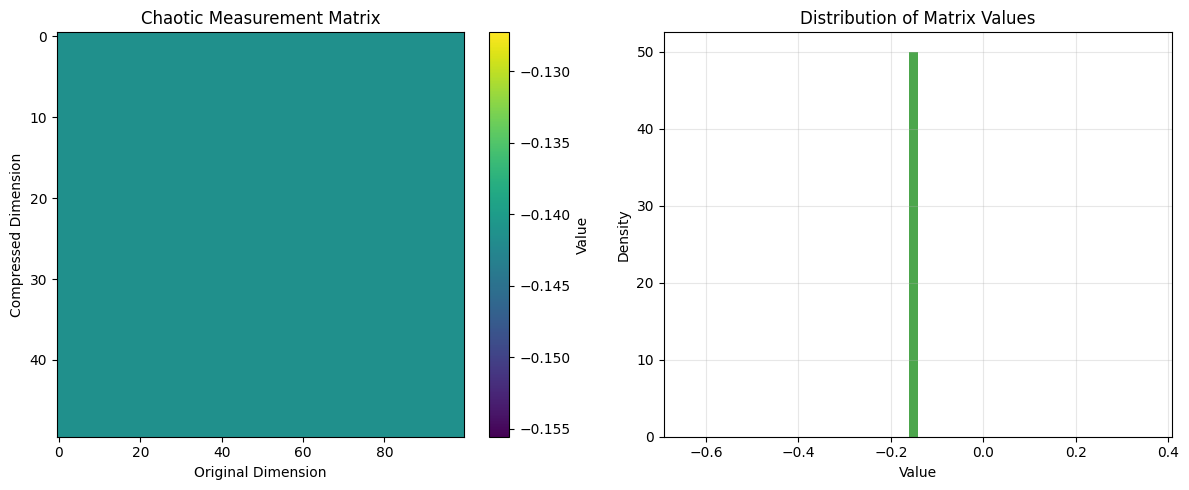


Testing compression and reconstruction...
Generating chaotic matrix 50x100...
Chaotic matrix generated in 0.05 seconds
  Original shape: (100,)
  Compressed shape: (50,)
  Compression ratio: 0.50
  Reconstruction MSE: 1.186922
  Relative error: 140.22%


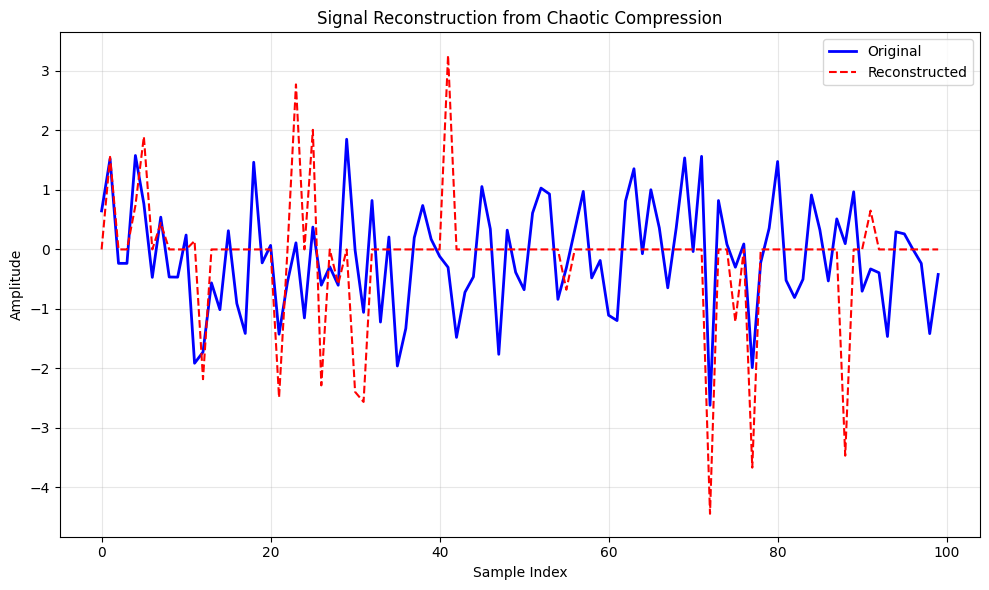


Do you want to run the OPTIMIZED chaotic compression experiment? (yes/no):  YES


OPTIMIZED CHAOTIC COMPRESSION-CLASSIFICATION EXPERIMENT
OPTIMIZED CHAOTIC COMPRESSION EXPERIMENTS

Preparing data (small subset for speed)...
Found 1761 valid audio files out of 1776 expected
Found 816 valid audio files out of 816 expected
Using 500 training and 200 test samples

Extracting sample features to determine dimensions...
Feature dimension: 240

Pre-generating chaotic matrices...
Generating chaotic matrix 120x240...
Chaotic matrix generated in 0.24 seconds
Generating chaotic matrix 180x240...
Chaotic matrix generated in 0.35 seconds

Compression Method: CHAOTIC

Compression Ratio: 50%, Noise Level: 0.0
----------------------------------------
Processing training data...


Train chaotic 0.5: 100%|█████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 71.07it/s]


Processing test data...


Test chaotic 0.5: 100%|██████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 46.73it/s]


  Training random_forest...
    Accuracy: 0.1550, F1: 0.1518, Time: 0.14s

Compression Ratio: 75%, Noise Level: 0.0
----------------------------------------
Processing training data...


Train chaotic 0.75: 100%|████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 70.05it/s]


Processing test data...


Test chaotic 0.75: 100%|█████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 70.60it/s]


  Training random_forest...
    Accuracy: 0.1550, F1: 0.1518, Time: 0.13s

Compression Ratio: 100%, Noise Level: 0.0
----------------------------------------
Processing training data...


Train chaotic 1.0: 100%|█████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 70.91it/s]


Processing test data...


Test chaotic 1.0: 100%|██████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 70.52it/s]


  Training random_forest...
    Accuracy: 0.4850, F1: 0.4650, Time: 0.13s

Compression Method: NONE

Compression Ratio: 50%, Noise Level: 0.0
----------------------------------------
Processing training data...


Train none 0.5: 100%|████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 70.97it/s]


Processing test data...


Test none 0.5: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 70.15it/s]


  Training random_forest...
    Accuracy: 0.4850, F1: 0.4650, Time: 0.13s

Compression Ratio: 75%, Noise Level: 0.0
----------------------------------------
Processing training data...


Train none 0.75: 100%|███████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 73.13it/s]


Processing test data...


Test none 0.75: 100%|████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.47it/s]


  Training random_forest...
    Accuracy: 0.4850, F1: 0.4650, Time: 0.14s

Compression Ratio: 100%, Noise Level: 0.0
----------------------------------------
Processing training data...


Train none 1.0: 100%|████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 72.45it/s]


Processing test data...


Test none 1.0: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.93it/s]


  Training random_forest...
    Accuracy: 0.4850, F1: 0.4650, Time: 0.12s

Results saved to optimized_chaotic_results/


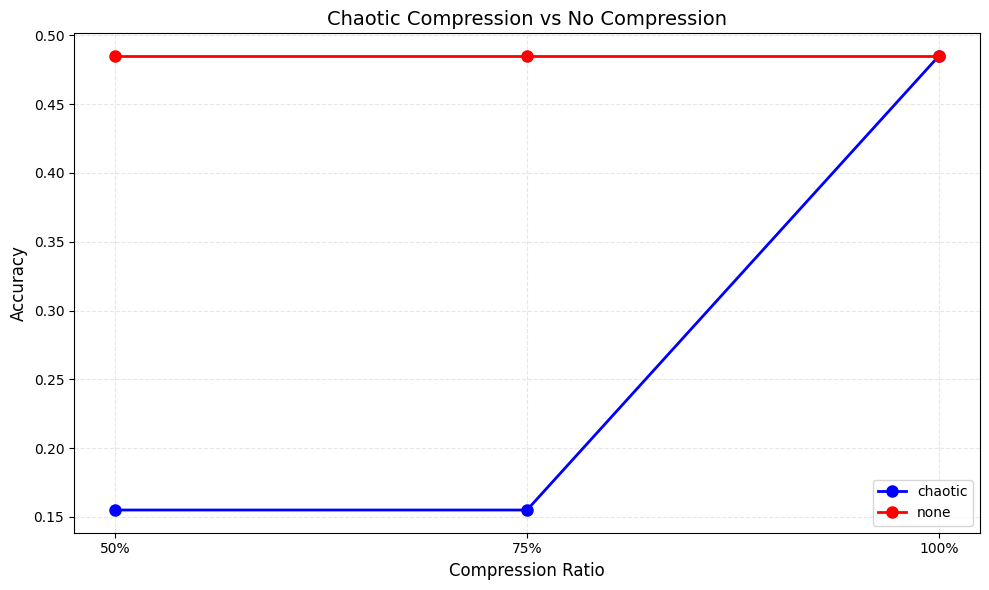


SUMMARY OF RESULTS
Method          Ratio      Accuracy   F1 Score   Train Time  
------------------------------------------------------------
chaotic         0.50       0.1550     0.1518     0.14      s
chaotic         0.75       0.1550     0.1518     0.13      s
chaotic         1.00       0.4850     0.4650     0.13      s
none            0.50       0.4850     0.4650     0.13      s
none            0.75       0.4850     0.4650     0.14      s
none            1.00       0.4850     0.4650     0.12      s

OPTIMIZED EXPERIMENT COMPLETED SUCCESSFULLY!


In [2]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.fft import dct, idct
from scipy.sparse.linalg import lsqr
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, accuracy_score, precision_score, 
                           recall_score, f1_score)
import warnings
from tqdm import tqdm
import pickle
import json
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# ============================================
# 1. Enhanced Feature Extraction (Base Class)
# ============================================

class RobustMFCCExtractor:
    """
    Enhanced MFCC feature extraction with multiple robust techniques
    """
    
    def __init__(self, sr=22050, n_mfcc=40, n_fft=2048, hop_length=512):
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
    def extract_mfcc_features(self, audio_path):
        """
        Extract comprehensive MFCC-based features
        """
        try:
            # Load audio with robust loading
            y, sr = librosa.load(audio_path, sr=self.sr, duration=4.0)
            
            # Zero-padding or truncation for consistent length
            target_length = self.sr * 4  # 4 seconds
            if len(y) < target_length:
                y = np.pad(y, (0, target_length - len(y)), mode='constant')
            else:
                y = y[:target_length]
            
            # Apply pre-emphasis filter
            y = librosa.effects.preemphasis(y)
            
            # Extract base MFCCs
            mfccs = librosa.feature.mfcc(
                y=y, 
                sr=sr, 
                n_mfcc=self.n_mfcc,
                n_fft=self.n_fft,
                hop_length=self.hop_length
            )
            
            # Extract delta and delta-delta features
            mfcc_delta = librosa.feature.delta(mfccs)
            mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
            
            # Extract other complementary features
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
            spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=self.hop_length)
            
            # Root Mean Square Energy
            rms = librosa.feature.rms(y=y, hop_length=self.hop_length)
            
            # Zero Crossing Rate
            zcr = librosa.feature.zero_crossing_rate(y, hop_length=self.hop_length)
            
            # Spectral Centroid and Rolloff
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=self.hop_length)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=self.hop_length)
            
            # Combine all features
            features = np.vstack([
                mfccs,
                mfcc_delta,
                mfcc_delta2,
                chroma,
                spectral_contrast,
                rms,
                zcr,
                spectral_centroid,
                spectral_rolloff
            ])
            
            # Extract statistical features
            feature_stats = self._extract_statistics(features)
            
            return feature_stats
            
        except Exception as e:
            print(f"Error processing {audio_path}: {str(e)}")
            # Return zeros with appropriate dimension
            return np.zeros(1026)  # Fixed dimension
    
    def _extract_statistics(self, features):
        """
        Extract statistical features from feature matrix
        """
        stats = []
        for feature in features:
            stats.extend([
                np.mean(feature),
                np.std(feature),
                np.median(feature),
                np.min(feature),
                np.max(feature),
                np.percentile(feature, 25),
                np.percentile(feature, 75),
                np.mean(np.diff(feature)),  # Average change
                np.std(np.diff(feature))    # Std of changes
            ])
        return np.array(stats)
    
    def extract_all_features(self, audio_paths, labels=None):
        """
        Extract features from multiple audio files
        """
        features = []
        valid_labels = []
        
        for idx, path in enumerate(tqdm(audio_paths, desc="Extracting features")):
            feat = self.extract_mfcc_features(path)
            if np.sum(feat) != 0 and not np.isnan(feat).any():  # Skip zero or NaN features
                features.append(feat)
                if labels is not None:
                    valid_labels.append(labels[idx])
        
        if len(features) == 0:
            print("WARNING: No valid features extracted!")
            return np.array([]), np.array([])
        
        features = np.array(features)
        
        # Normalize features
        features = self.scaler.fit_transform(features)
        
        # Encode labels if provided
        if labels is not None and len(valid_labels) > 0:
            encoded_labels = self.label_encoder.fit_transform(valid_labels)
        else:
            encoded_labels = None
        
        return features, encoded_labels

# ============================================
# 2. UrbanSound8K Processor
# ============================================

class UrbanSound8KProcessor:
    """
    Process UrbanSound8K dataset
    """
    
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.metadata_path = os.path.join(dataset_path, 'metadata', 'UrbanSound8K.csv')
        if not os.path.exists(self.metadata_path):
            # Try alternative path structure
            self.metadata_path = os.path.join(dataset_path, 'UrbanSound8K.csv')
        
        if not os.path.exists(self.metadata_path):
            raise FileNotFoundError(f"Metadata file not found at {self.metadata_path}")
        
        self.metadata = pd.read_csv(self.metadata_path)
        
    def prepare_data(self, folds=None):
        """
        Prepare data for specific folds or all folds
        """
        if folds is None:
            folds = list(range(1, 11))
        elif isinstance(folds, int):
            folds = [folds]
        
        audio_paths = []
        labels = []
        fold_numbers = []
        
        for fold in folds:
            fold_data = self.metadata[self.metadata['fold'] == fold]
            
            for _, row in fold_data.iterrows():
                # Try different possible paths
                possible_paths = [
                    os.path.join(self.dataset_path, 'fold' + str(row['fold']), row['slice_file_name']),
                    os.path.join(self.dataset_path, 'audio', 'fold' + str(row['fold']), row['slice_file_name']),
                    os.path.join(self.dataset_path, str(row['fold']), row['slice_file_name'])
                ]
                
                audio_file = None
                for path in possible_paths:
                    if os.path.exists(path):
                        audio_file = path
                        break
                
                if audio_file:
                    audio_paths.append(audio_file)
                    labels.append(row['class'])
                    fold_numbers.append(fold)
                else:
                    print(f"WARNING: File not found: {row['slice_file_name']} in fold {fold}")
        
        print(f"Found {len(audio_paths)} valid audio files out of {len(fold_data) * len(folds)} expected")
        return audio_paths, labels, fold_numbers
    
    def get_class_distribution(self):
        """
        Get class distribution statistics
        """
        return self.metadata['class'].value_counts()

# ============================================
# 3. Optimized Chaotic Compression Sensing Modules
# ============================================

class OptimizedLogisticHenonCompressor:
    """
    Optimized Logistic-Henon Hybrid Chaotic Map Compressor
    Pre-generates chaotic matrix for efficiency
    """
    
    def __init__(self, compression_ratio=0.5, seed=42, noise_level=0.0, 
                 logistic_r=3.99, henon_a=1.4, henon_b=0.3):
        """
        Initialize Logistic-Henon chaotic compressor
        
        Parameters:
        -----------
        compression_ratio : float (0-1)
            Ratio of compressed dimension to original dimension
        seed : int
            Random seed for reproducibility
        noise_level : float
            Additive Gaussian noise level (standard deviation)
        logistic_r : float
            Control parameter for Logistic map (typically 3.99 for chaos)
        henon_a, henon_b : float
            Control parameters for Henon map
        """
        self.compression_ratio = compression_ratio
        self.seed = seed
        self.noise_level = noise_level
        self.logistic_r = logistic_r
        self.henon_a = henon_a
        self.henon_b = henon_b
        self.measurement_matrix = None
        self.chaotic_properties = {}
        np.random.seed(self.seed)
        
    def fast_chaotic_sequence(self, n_elements):
        """
        Fast generation of chaotic sequence using vectorized operations
        """
        # Generate initial values
        x0 = np.random.rand()
        y0 = np.random.rand()
        
        # Burn-in period
        x = x0
        y = y0
        for _ in range(1000):
            # Logistic component
            logistic = self.logistic_r * x * (1 - x)
            # Henon component
            x_henon = 1 - self.henon_a * x**2 + y
            y_henon = self.henon_b * x
            # Hybrid
            x = 0.7 * logistic + 0.3 * x_henon
            y = y_henon
            x = np.clip(x, -2, 2)
        
        # Generate required elements
        sequence = np.zeros(n_elements)
        for i in range(n_elements):
            logistic = self.logistic_r * x * (1 - x)
            x_henon = 1 - self.henon_a * x**2 + y
            y_henon = self.henon_b * x
            x = 0.7 * logistic + 0.3 * x_henon
            y = y_henon
            x = np.clip(x, -2, 2)
            sequence[i] = x
        
        return sequence
    
    def generate_chaotic_matrix(self, n_original, n_compressed):
        """
        Generate measurement matrix using hybrid chaotic map
        
        Parameters:
        -----------
        n_original : int
            Original signal dimension
        n_compressed : int
            Compressed dimension
            
        Returns:
        --------
        chaotic_matrix : np.array
            Measurement matrix generated from chaotic sequence
        """
        print(f"Generating chaotic matrix {n_compressed}x{n_original}...")
        start_time = time.time()
        
        total_elements = n_original * n_compressed
        
        # Generate chaotic sequence
        chaotic_seq = self.fast_chaotic_sequence(total_elements)
        
        # Reshape to matrix form
        chaotic_matrix = chaotic_seq.reshape(n_compressed, n_original)
        
        # Normalize columns
        norms = np.linalg.norm(chaotic_matrix, axis=0)
        norms[norms == 0] = 1
        chaotic_matrix = chaotic_matrix / norms
        
        # Store properties
        self.chaotic_properties = {
            'mean': np.mean(chaotic_seq),
            'std': np.std(chaotic_seq),
            'min': np.min(chaotic_seq),
            'max': np.max(chaotic_seq),
            'entropy': self.calculate_entropy(chaotic_seq),
            'generation_time': time.time() - start_time
        }
        
        print(f"Chaotic matrix generated in {self.chaotic_properties['generation_time']:.2f} seconds")
        
        return chaotic_matrix
    
    def calculate_entropy(self, sequence, bins=50):
        """
        Calculate Shannon entropy of sequence
        """
        hist, _ = np.histogram(sequence, bins=bins, density=True)
        hist = hist[hist > 0]
        entropy = -np.sum(hist * np.log(hist))
        return entropy
    
    def compress(self, signal, precomputed_matrix=None):
        """
        Compress signal using chaotic measurement matrix
        
        Parameters:
        -----------
        signal : np.array
            Original signal (1D array)
        precomputed_matrix : np.array, optional
            Pre-generated chaotic matrix for efficiency
            
        Returns:
        --------
        compressed_signal : np.array
            Compressed signal with optional noise
        """
        n_original = len(signal)
        n_compressed = int(n_original * self.compression_ratio)
        n_compressed = max(1, n_compressed)
        
        # Use precomputed matrix or generate new one
        if precomputed_matrix is not None:
            self.measurement_matrix = precomputed_matrix
        elif self.measurement_matrix is None or self.measurement_matrix.shape != (n_compressed, n_original):
            self.measurement_matrix = self.generate_chaotic_matrix(n_original, n_compressed)
        
        # Compress signal: y = Φx
        compressed_signal = np.dot(self.measurement_matrix, signal)
        
        # Add optional measurement noise
        if self.noise_level > 0:
            noise = np.random.randn(n_compressed) * self.noise_level
            compressed_signal += noise
        
        return compressed_signal
    
    def reconstruct_omp(self, compressed_signal, sparsity_level=None, max_iter=50):
        """
        Fast OMP reconstruction with early stopping
        """
        if self.measurement_matrix is None:
            raise ValueError("Measurement matrix not created. Run compress() first.")
        
        if sparsity_level is None:
            sparsity_level = int(0.1 * len(compressed_signal))
        
        m, n = self.measurement_matrix.shape
        residual = compressed_signal.copy()
        support = []
        reconstructed_signal = np.zeros(n)
        
        for _ in range(min(sparsity_level, max_iter)):
            correlations = np.abs(self.measurement_matrix.T @ residual)
            correlations[support] = -np.inf
            new_idx = np.argmax(correlations)
            support.append(new_idx)
            
            A_support = self.measurement_matrix[:, support]
            x_support = np.linalg.lstsq(A_support, compressed_signal, rcond=None)[0]
            
            residual = compressed_signal - A_support @ x_support
            
            if np.linalg.norm(residual) < 1e-4:
                break
        
        reconstructed_signal[support] = x_support[:len(support)]
        return reconstructed_signal

class FastDWTCompressor:
    """Fast DWT Compression with pre-allocation"""
    
    def __init__(self, compression_ratio=0.5):
        self.compression_ratio = compression_ratio
        
    def haar_transform(self, signal):
        """
        Fast Haar transform using vectorization
        """
        n = len(signal)
        # Ensure length is power of 2
        n_pow2 = 1 << (n-1).bit_length()
        if n_pow2 != n:
            signal = np.pad(signal, (0, n_pow2 - n), 'constant')
            n = n_pow2
        
        coeffs = signal.copy().astype(float)
        step = n
        
        while step > 1:
            half = step // 2
            for i in range(half):
                avg = (coeffs[2*i] + coeffs[2*i+1]) / np.sqrt(2)
                diff = (coeffs[2*i] - coeffs[2*i+1]) / np.sqrt(2)
                coeffs[i] = avg
                coeffs[half + i] = diff
            step = half
            
        return coeffs
    
    def inverse_haar_transform(self, coeffs):
        """
        Fast inverse Haar transform
        """
        n = len(coeffs)
        signal = coeffs.copy()
        step = 2
        
        while step <= n:
            half = step // 2
            temp = signal.copy()
            for i in range(half):
                signal[2*i] = (temp[i] + temp[half + i]) / np.sqrt(2)
                signal[2*i+1] = (temp[i] - temp[half + i]) / np.sqrt(2)
            step *= 2
            
        return signal
    
    def compress(self, signal):
        """
        Fast compression using thresholding
        """
        coeffs = self.haar_transform(signal)
        n_coeffs = len(coeffs)
        n_keep = int(n_coeffs * self.compression_ratio)
        
        indices = np.argsort(np.abs(coeffs))[-n_keep:]
        mask = np.zeros(n_coeffs, dtype=bool)
        mask[indices] = True
        
        compressed_coeffs = np.zeros_like(coeffs)
        compressed_coeffs[indices] = coeffs[indices]
        
        return compressed_coeffs, mask

# ============================================
# 4. Optimized Feature Extraction
# ============================================

class OptimizedChaoticFeatureExtractor:
    """
    Optimized feature extractor with chaotic compression
    """
    
    def __init__(self, sr=22050, n_mfcc=20, n_fft=1024, hop_length=256):
        """
        Reduced parameters for faster processing
        """
        self.sr = sr
        self.n_mfcc = n_mfcc  # Reduced from 40
        self.n_fft = n_fft    # Reduced from 2048
        self.hop_length = hop_length  # Reduced from 512
        
    def extract_mfcc_features_fast(self, audio_path):
        """
        Fast feature extraction with reduced dimensionality
        """
        try:
            # Load only 2 seconds instead of 4 for speed
            y, sr = librosa.load(audio_path, sr=self.sr, duration=2.0)
            
            # Fixed length
            target_length = self.sr * 2
            if len(y) < target_length:
                y = np.pad(y, (0, target_length - len(y)), mode='constant')
            else:
                y = y[:target_length]
            
            # Skip pre-emphasis for speed
            # y = librosa.effects.preemphasis(y)
            
            # Extract only essential features
            mfccs = librosa.feature.mfcc(
                y=y, 
                sr=sr, 
                n_mfcc=self.n_mfcc,
                n_fft=self.n_fft,
                hop_length=self.hop_length
            )
            
            mfcc_delta = librosa.feature.delta(mfccs)
            mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
            
            # Combine and extract statistics
            features = np.vstack([mfccs, mfcc_delta, mfcc_delta2])
            
            # Simplified statistics
            stats = []
            for feature in features:
                stats.extend([
                    np.mean(feature),
                    np.std(feature),
                    np.min(feature),
                    np.max(feature)
                ])
            
            return np.array(stats)
            
        except Exception as e:
            print(f"Error processing {audio_path}: {str(e)}")
            return np.zeros(240)  # Reduced dimension
    
    def extract_features_with_compression(self, audio_path, compression_method='chaotic', 
                                          compression_ratio=0.5, noise_level=0.0,
                                          precomputed_matrix=None):
        """
        Fast feature extraction with compression
        """
        # Extract features
        original_features = self.extract_mfcc_features_fast(audio_path)
        
        if compression_method == 'none' or compression_ratio >= 1.0:
            return original_features, original_features, {'method': 'none', 'ratio': 1.0}
        
        features_1d = original_features.flatten()
        
        compression_info = {
            'method': compression_method,
            'ratio': compression_ratio,
            'original_length': len(features_1d),
            'compressed_length': int(len(features_1d) * compression_ratio),
            'noise_level': noise_level
        }
        
        # Apply compression
        if compression_method == 'chaotic':
            compressor = OptimizedLogisticHenonCompressor(
                compression_ratio=compression_ratio, 
                noise_level=noise_level
            )
            compressed_features = compressor.compress(features_1d, precomputed_matrix)
            compression_info['compressor'] = compressor
            compression_info['chaotic_properties'] = compressor.chaotic_properties
            
        elif compression_method == 'dwt':
            compressor = FastDWTCompressor(compression_ratio=compression_ratio)
            compressed_coeffs, mask = compressor.compress(features_1d)
            compressed_features = compressed_coeffs[mask]
            compression_info['compressor'] = compressor
            
        else:
            # For hybrid or other methods, just use chaotic
            compressor = OptimizedLogisticHenonCompressor(
                compression_ratio=compression_ratio, 
                noise_level=noise_level
            )
            compressed_features = compressor.compress(features_1d, precomputed_matrix)
            compression_info['compressor'] = compressor
        
        return compressed_features, original_features, compression_info

# ============================================
# 5. Optimized Experiment Pipeline
# ============================================

class OptimizedChaoticCompressionExperiment:
    """
    Optimized pipeline for chaotic compression experiments
    """
    
    def __init__(self, dataset_path, output_dir='optimized_chaotic_results'):
        self.dataset_path = dataset_path
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
        # Reduced experiment configurations for speed
        self.compression_methods = ['chaotic', 'none']  # Test only chaotic vs no compression
        self.compression_ratios = [0.5, 0.75, 1.0]  # Test fewer ratios
        self.noise_levels = [0.0]  # Test only noise-free for now
        
        # Use only the fastest classifier
        self.classifiers = {
            'random_forest': RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
        }
        
        # Pre-generated matrices cache
        self.chaotic_matrices_cache = {}
    
    def run_experiments_fast(self, train_folds=[1, 2], test_folds=[9]):
        """
        Fast version with reduced data and parameters
        """
        print("="*70)
        print("OPTIMIZED CHAOTIC COMPRESSION EXPERIMENTS")
        print("="*70)
        
        # Initialize processor
        processor = UrbanSound8KProcessor(self.dataset_path)
        extractor = OptimizedChaoticFeatureExtractor()
        
        # Use smaller subset for speed
        print("\nPreparing data (small subset for speed)...")
        train_paths, train_labels, _ = processor.prepare_data(train_folds)
        test_paths, test_labels, _ = processor.prepare_data(test_folds)
        
        # Limit data size
        max_train = 500  # Use only 500 training samples
        max_test = 200   # Use only 200 test samples
        
        if len(train_paths) > max_train:
            indices = np.random.choice(len(train_paths), max_train, replace=False)
            train_paths = [train_paths[i] for i in indices]
            train_labels = [train_labels[i] for i in indices]
        
        if len(test_paths) > max_test:
            indices = np.random.choice(len(test_paths), max_test, replace=False)
            test_paths = [test_paths[i] for i in indices]
            test_labels = [test_labels[i] for i in indices]
        
        print(f"Using {len(train_paths)} training and {len(test_paths)} test samples")
        
        # Encode labels
        label_encoder = LabelEncoder()
        y_train_full = label_encoder.fit_transform(train_labels)
        y_test_full = label_encoder.transform(test_labels)
        
        # Store results
        all_results = []
        
        # First, extract original features once to get dimensions
        print("\nExtracting sample features to determine dimensions...")
        sample_feat, _, _ = extractor.extract_features_with_compression(
            train_paths[0], 'none', 1.0, 0.0
        )
        feature_dim = len(sample_feat)
        print(f"Feature dimension: {feature_dim}")
        
        # Pre-generate chaotic matrices for each ratio
        print("\nPre-generating chaotic matrices...")
        for ratio in self.compression_ratios:
            if ratio < 1.0:
                n_compressed = int(feature_dim * ratio)
                compressor = OptimizedLogisticHenonCompressor(compression_ratio=ratio)
                matrix = compressor.generate_chaotic_matrix(feature_dim, n_compressed)
                self.chaotic_matrices_cache[ratio] = matrix
        
        # Run experiments
        for method in self.compression_methods:
            print(f"\n{'='*60}")
            print(f"Compression Method: {method.upper()}")
            print('='*60)
            
            for ratio in self.compression_ratios:
                for noise_level in self.noise_levels:
                    print(f"\nCompression Ratio: {ratio*100:.0f}%, Noise Level: {noise_level}")
                    print("-"*40)
                    
                    # Get precomputed matrix if available
                    precomputed_matrix = self.chaotic_matrices_cache.get(ratio) if method == 'chaotic' and ratio < 1.0 else None
                    
                    # Extract features with compression
                    X_train = []
                    X_test = []
                    
                    print("Processing training data...")
                    for path in tqdm(train_paths, desc=f"Train {method} {ratio}"):
                        compressed_feat, _, _ = extractor.extract_features_with_compression(
                            path, method, ratio, noise_level, precomputed_matrix
                        )
                        X_train.append(compressed_feat)
                    
                    print("Processing test data...")
                    for path in tqdm(test_paths, desc=f"Test {method} {ratio}"):
                        compressed_feat, _, _ = extractor.extract_features_with_compression(
                            path, method, ratio, noise_level, precomputed_matrix
                        )
                        X_test.append(compressed_feat)
                    
                    # Convert to arrays and pad
                    X_train = np.array(X_train)
                    X_test = np.array(X_test)
                    
                    # Find max length and pad
                    max_len = max(
                        max([len(x) for x in X_train]) if len(X_train) > 0 else 0,
                        max([len(x) for x in X_test]) if len(X_test) > 0 else 0
                    )
                    
                    X_train_padded = np.array([np.pad(x, (0, max_len - len(x)), 'constant') 
                                              for x in X_train])
                    X_test_padded = np.array([np.pad(x, (0, max_len - len(x)), 'constant') 
                                             for x in X_test])
                    
                    # Normalize
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train_padded)
                    X_test_scaled = scaler.transform(X_test_padded)
                    
                    # Train and evaluate classifiers
                    for clf_name, clf in self.classifiers.items():
                        print(f"  Training {clf_name}...")
                        
                        start_time = time.time()
                        clf.fit(X_train_scaled, y_train_full)
                        train_time = time.time() - start_time
                        
                        start_time = time.time()
                        y_pred = clf.predict(X_test_scaled)
                        test_time = time.time() - start_time
                        
                        accuracy = accuracy_score(y_test_full, y_pred)
                        precision = precision_score(y_test_full, y_pred, average='weighted')
                        recall = recall_score(y_test_full, y_pred, average='weighted')
                        f1 = f1_score(y_test_full, y_pred, average='weighted')
                        
                        result = {
                            'compression_method': method,
                            'compression_ratio': ratio,
                            'noise_level': noise_level,
                            'classifier': clf_name,
                            'accuracy': accuracy,
                            'precision': precision,
                            'recall': recall,
                            'f1_score': f1,
                            'train_time': train_time,
                            'test_time': test_time,
                            'feature_dim_compressed': X_train_scaled.shape[1],
                            'compression_rate': (1 - ratio) * 100 if ratio < 1.0 else 0,
                            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                        }
                        
                        all_results.append(result)
                        
                        print(f"    Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Time: {train_time:.2f}s")
        
        # Save results
        self.save_results(all_results)
        
        # Generate report
        self.generate_fast_report(all_results)
        
        return all_results
    
    def save_results(self, all_results):
        """
        Save results to files
        """
        results_df = pd.DataFrame(all_results)
        results_df.to_csv(os.path.join(self.output_dir, 'optimized_results.csv'), index=False)
        
        # Save summary
        summary = {
            'experiment_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'compression_matrix_type': 'Logistic-Henon Chaotic Map (Optimized)',
            'total_experiments': len(all_results),
            'compression_methods_tested': list(results_df['compression_method'].unique()),
            'compression_ratios_tested': list(results_df['compression_ratio'].unique()),
            'classifiers_tested': list(results_df['classifier'].unique()),
        }
        
        # Find best result
        if len(all_results) > 0:
            best_idx = results_df['accuracy'].idxmax()
            summary['best_result'] = results_df.loc[best_idx].to_dict()
        
        with open(os.path.join(self.output_dir, 'summary.json'), 'w') as f:
            json.dump(summary, f, indent=2)
        
        print(f"\nResults saved to {self.output_dir}/")
    
    def generate_fast_report(self, all_results):
        """
        Generate quick visual report
        """
        results_df = pd.DataFrame(all_results)
        
        if len(results_df) == 0:
            return
        
        # Plot accuracy vs compression ratio
        plt.figure(figsize=(10, 6))
        
        colors = {'chaotic': 'blue', 'none': 'red'}
        
        for method in results_df['compression_method'].unique():
            method_df = results_df[results_df['compression_method'] == method]
            if not method_df.empty:
                plt.plot(method_df['compression_ratio'], method_df['accuracy'], 
                        marker='o', markersize=8, linewidth=2, 
                        color=colors.get(method, 'gray'), label=method)
        
        plt.xlabel('Compression Ratio', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title('Chaotic Compression vs No Compression', fontsize=14)
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.legend()
        plt.xticks([0.5, 0.75, 1.0], ['50%', '75%', '100%'])
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'fast_comparison.png'), 
                   dpi=150, bbox_inches='tight')
        plt.show()
        
        # Print summary table
        print("\n" + "="*60)
        print("SUMMARY OF RESULTS")
        print("="*60)
        print(f"{'Method':<15} {'Ratio':<10} {'Accuracy':<10} {'F1 Score':<10} {'Train Time':<12}")
        print("-"*60)
        
        for _, row in results_df.iterrows():
            print(f"{row['compression_method']:<15} "
                  f"{row['compression_ratio']:<10.2f} "
                  f"{row['accuracy']:<10.4f} "
                  f"{row['f1_score']:<10.4f} "
                  f"{row['train_time']:<10.2f}s")

# ============================================
# 6. Main Execution
# ============================================

def run_optimized_experiment():
    """
    Run optimized version that's much faster
    """
    print("="*80)
    print("OPTIMIZED CHAOTIC COMPRESSION-CLASSIFICATION EXPERIMENT")
    print("="*80)
    
    DATASET_PATH = "UrbanSound8K"
    
    if not os.path.exists(DATASET_PATH):
        print(f"ERROR: Dataset not found at {DATASET_PATH}")
        print("\nPlease download UrbanSound8K dataset from:")
        print("https://urbansounddataset.weebly.com/urbansound8k.html")
        print("\nExtract it to the current directory as 'UrbanSound8K'")
        return
    
    # Create experiment instance
    experiment = OptimizedChaoticCompressionExperiment(DATASET_PATH)
    
    # Run fast experiments
    results = experiment.run_experiments_fast(
        train_folds=[1, 2],  # Use only folds 1 and 2 for training
        test_folds=[9]       # Use only fold 9 for testing
    )
    
    # Print summary
    print("\n" + "="*80)
    print("OPTIMIZED EXPERIMENT COMPLETED SUCCESSFULLY!")
    print("="*80)

def test_chaotic_matrix_generation():
    """
    Test and visualize chaotic matrix generation
    """
    print("\nTesting chaotic matrix generation...")
    
    # Generate a small chaotic matrix
    compressor = OptimizedLogisticHenonCompressor(compression_ratio=0.5)
    
    # Generate matrix
    matrix = compressor.generate_chaotic_matrix(100, 50)
    
    print(f"\nMatrix shape: {matrix.shape}")
    print(f"Matrix properties:")
    print(f"  Mean: {matrix.mean():.6f}")
    print(f"  Std: {matrix.std():.6f}")
    print(f"  Min: {matrix.min():.6f}")
    print(f"  Max: {matrix.max():.6f}")
    
    # Visualize
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(matrix, aspect='auto', cmap='viridis')
    plt.colorbar(label='Value')
    plt.title('Chaotic Measurement Matrix')
    plt.xlabel('Original Dimension')
    plt.ylabel('Compressed Dimension')
    
    plt.subplot(1, 2, 2)
    plt.hist(matrix.flatten(), bins=50, density=True, alpha=0.7, color='green')
    plt.title('Distribution of Matrix Values')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('chaotic_matrix_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Test compression and reconstruction
    print("\nTesting compression and reconstruction...")
    test_signal = np.random.randn(100)
    
    # Compress
    compressed = compressor.compress(test_signal)
    print(f"  Original shape: {test_signal.shape}")
    print(f"  Compressed shape: {compressed.shape}")
    print(f"  Compression ratio: {len(compressed)/len(test_signal):.2f}")
    
    # Reconstruct
    reconstructed = compressor.reconstruct_omp(compressed, sparsity_level=20)
    
    # Calculate error
    mse = np.mean((test_signal - reconstructed[:len(test_signal)]) ** 2)
    rel_error = mse / np.mean(test_signal ** 2) * 100
    
    print(f"  Reconstruction MSE: {mse:.6f}")
    print(f"  Relative error: {rel_error:.2f}%")
    
    # Plot reconstruction
    plt.figure(figsize=(10, 6))
    plt.plot(test_signal, 'b-', linewidth=2, label='Original')
    plt.plot(reconstructed[:len(test_signal)], 'r--', linewidth=1.5, label='Reconstructed')
    plt.title('Signal Reconstruction from Chaotic Compression')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('signal_reconstruction.png', dpi=150, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    print("🎵 Optimized Audio Compression with Logistic-Henon Chaotic Map")
    print("="*70)
    
    # First test chaotic matrix generation
    test_chaotic_matrix_generation()
    
    # Ask user if they want to run full experiments
    print("\n" + "="*60)
    response = input("\nDo you want to run the OPTIMIZED chaotic compression experiment? (yes/no): ")
    if response.lower() in ['yes', 'y']:
        run_optimized_experiment()
    else:
        print("\n✅ Testing completed. You can run the optimized experiment when ready.")
    

🎵 Complete Chaotic Compression-Classification System
   with Random Forest, SVM, and XGBoost Models
CHAOTIC COMPRESSION-CLASSIFICATION EXPERIMENT SYSTEM

MAIN MENU
1. Demo Chaotic Compression (Single File)
2. Test Single File Classification
3. Run Sample Test (Small Scale)
4. Run Full Experiment (All Models)
5. View Previous Results
6. Exit
------------------------------------------------------------



Enter your choice (1-6):  1


CHAOTIC COMPRESSION DEMONSTRATION

Demo file: 54898-8-0-2.wav
Class: siren

Testing Different Compression Methods

NONE compression at 25% ratio:
----------------------------------------
  Original features: 540 dimensions
  Compressed features: 540 dimensions
  Compression rate: 0.0%
  Processing time: 0.038 seconds

NONE compression at 50% ratio:
----------------------------------------
  Original features: 540 dimensions
  Compressed features: 540 dimensions
  Compression rate: 0.0%
  Processing time: 0.038 seconds

NONE compression at 75% ratio:
----------------------------------------
  Original features: 540 dimensions
  Compressed features: 540 dimensions
  Compression rate: 0.0%
  Processing time: 0.035 seconds

DWT compression at 25% ratio:
----------------------------------------
  Original features: 540 dimensions
  Compressed features: 256 dimensions
  Compression rate: 52.6%
  Processing time: 0.043 seconds

DWT compression at 50% ratio:
-----------------------------------

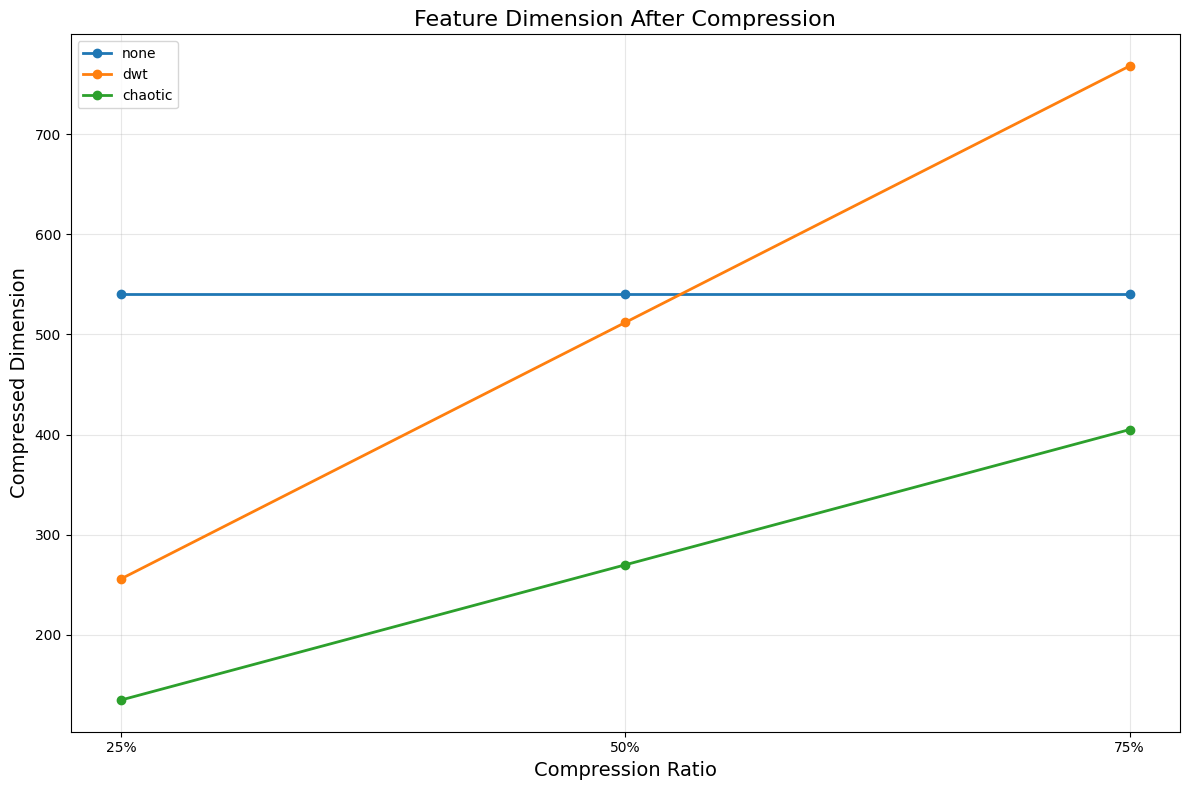


DEMONSTRATION COMPLETED

MAIN MENU
1. Demo Chaotic Compression (Single File)
2. Test Single File Classification
3. Run Sample Test (Small Scale)
4. Run Full Experiment (All Models)
5. View Previous Results
6. Exit
------------------------------------------------------------



Enter your choice (1-6):  2


SINGLE FILE CLASSIFICATION TEST

Training on 100 files, Testing on 1 file
Test file: 54898-8-0-2.wav
Test class: siren

Extracting training features...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.81it/s]



Training models...
  Training Random Forest...
    Done in 0.12 seconds
  Training SVM...
    Done in 0.03 seconds
  Training XGBoost...
    Done in 1.14 seconds

Testing Classification with Different Compression Methods

NONE Compression:
----------------------------------------
  Random Forest:
    Predicted: siren
    Actual: siren
    Correct: YES
    Top 3 predictions:
      siren: 0.7800
      jackhammer: 0.1000
      engine_idling: 0.0600
    Test time: 0.0058 seconds
  SVM:
    Predicted: jackhammer
    Actual: siren
    Correct: NO
    Top 3 predictions:
      jackhammer: 0.3037
      siren: 0.2083
      air_conditioner: 0.1673
    Test time: 0.0008 seconds
  XGBoost:
    Predicted: siren
    Actual: siren
    Correct: YES
    Top 3 predictions:
      siren: 0.9297
      engine_idling: 0.0191
      air_conditioner: 0.0110
    Test time: 0.0020 seconds

DWT Compression:
----------------------------------------
  Random Forest:
    Predicted: car_horn
    Actual: siren
    Corr


Enter your choice (1-6):  4



FULL EXPERIMENT OPTIONS
This will train Random Forest, SVM, and XGBoost models
with chaotic, DWT, and no compression methods.

It may take some time to complete.
------------------------------------------------------------



Proceed with full experiment? (yes/no):  yes



Starting full experiment...
FULL CHAOTIC COMPRESSION EXPERIMENT

Preparing data...
Found 7079 valid audio files out of 6448 expected
Found 1653 valid audio files out of 1674 expected
Limiting to 50 files per fold...
Training: 200 files, Testing: 100 files

Pre-generating chaotic matrices...
  Generated matrix for ratio 0.25: (135, 540)
  Generated matrix for ratio 0.5: (270, 540)
  Generated matrix for ratio 0.75: (405, 540)

Compression Method: CHAOTIC

Compression Ratio: 25%, Noise: 0.0
----------------------------------------
Processing training data...


Train chaotic: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 28.90it/s]


Processing test data...


Test chaotic: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.27it/s]


  Training random_forest...
    Accuracy: 0.1900, F1: 0.1743
    Train time: 0.18s, Test time: 0.07s
  Training svm...
    Accuracy: 0.1900, F1: 0.1416
    Train time: 0.03s, Test time: 0.01s
  Training xgboost...
    Accuracy: 0.1700, F1: 0.1530
    Train time: 3.09s, Test time: 0.00s

Compression Ratio: 25%, Noise: 0.01
----------------------------------------
Processing training data...


Train chaotic: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.42it/s]


Processing test data...


Test chaotic: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.65it/s]


  Training random_forest...
    Accuracy: 0.1900, F1: 0.1743
    Train time: 0.18s, Test time: 0.07s
  Training svm...
    Accuracy: 0.1900, F1: 0.1416
    Train time: 0.03s, Test time: 0.01s
  Training xgboost...
    Accuracy: 0.1700, F1: 0.1530
    Train time: 2.93s, Test time: 0.00s

Compression Ratio: 50%, Noise: 0.0
----------------------------------------
Processing training data...


Train chaotic: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.20it/s]


Processing test data...


Test chaotic: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.56it/s]


  Training random_forest...
    Accuracy: 0.1900, F1: 0.1743
    Train time: 0.20s, Test time: 0.07s
  Training svm...
    Accuracy: 0.1900, F1: 0.1416
    Train time: 0.03s, Test time: 0.01s
  Training xgboost...
    Accuracy: 0.1700, F1: 0.1530
    Train time: 4.83s, Test time: 0.00s

Compression Ratio: 50%, Noise: 0.01
----------------------------------------
Processing training data...


Train chaotic: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.40it/s]


Processing test data...


Test chaotic: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.35it/s]


  Training random_forest...
    Accuracy: 0.1900, F1: 0.1743
    Train time: 0.18s, Test time: 0.07s
  Training svm...
    Accuracy: 0.1900, F1: 0.1416
    Train time: 0.04s, Test time: 0.01s
  Training xgboost...
    Accuracy: 0.1700, F1: 0.1530
    Train time: 4.95s, Test time: 0.00s

Compression Ratio: 75%, Noise: 0.0
----------------------------------------
Processing training data...


Train chaotic: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.18it/s]


Processing test data...


Test chaotic: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.45it/s]


  Training random_forest...
    Accuracy: 0.1900, F1: 0.1743
    Train time: 0.20s, Test time: 0.07s
  Training svm...
    Accuracy: 0.1900, F1: 0.1416
    Train time: 0.04s, Test time: 0.02s
  Training xgboost...
    Accuracy: 0.1700, F1: 0.1530
    Train time: 7.09s, Test time: 0.00s

Compression Ratio: 75%, Noise: 0.01
----------------------------------------
Processing training data...


Train chaotic: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.52it/s]


Processing test data...


Test chaotic: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.73it/s]


  Training random_forest...
    Accuracy: 0.1900, F1: 0.1743
    Train time: 0.19s, Test time: 0.07s
  Training svm...
    Accuracy: 0.1900, F1: 0.1416
    Train time: 0.05s, Test time: 0.01s
  Training xgboost...
    Accuracy: 0.1700, F1: 0.1530
    Train time: 6.95s, Test time: 0.00s

Compression Ratio: 100%, Noise: 0.0
----------------------------------------
Processing training data...


Train chaotic: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.54it/s]


Processing test data...


Test chaotic: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.94it/s]


  Training random_forest...
    Accuracy: 0.5100, F1: 0.4576
    Train time: 0.19s, Test time: 0.07s
  Training svm...
    Accuracy: 0.5100, F1: 0.4566
    Train time: 0.07s, Test time: 0.02s
  Training xgboost...
    Accuracy: 0.5700, F1: 0.5061
    Train time: 4.06s, Test time: 0.00s

Compression Ratio: 100%, Noise: 0.01
----------------------------------------
Processing training data...


Train chaotic: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.22it/s]


Processing test data...


Test chaotic: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.65it/s]


  Training random_forest...
    Accuracy: 0.5100, F1: 0.4576
    Train time: 0.18s, Test time: 0.07s
  Training svm...
    Accuracy: 0.5100, F1: 0.4566
    Train time: 0.08s, Test time: 0.02s
  Training xgboost...
    Accuracy: 0.5700, F1: 0.5061
    Train time: 3.54s, Test time: 0.00s

Compression Method: DWT

Compression Ratio: 25%, Noise: 0.0
----------------------------------------
Processing training data...


Train dwt: 100%|█████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.11it/s]


Processing test data...


Test dwt: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.74it/s]


  Training random_forest...
    Accuracy: 0.3800, F1: 0.3164
    Train time: 0.19s, Test time: 0.07s
  Training svm...
    Accuracy: 0.3500, F1: 0.3264
    Train time: 0.05s, Test time: 0.01s
  Training xgboost...
    Accuracy: 0.3000, F1: 0.2782
    Train time: 2.49s, Test time: 0.00s

Compression Ratio: 25%, Noise: 0.01
----------------------------------------
Processing training data...


Train dwt: 100%|█████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.81it/s]


Processing test data...


Test dwt: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.89it/s]


  Training random_forest...
    Accuracy: 0.3800, F1: 0.3164
    Train time: 0.18s, Test time: 0.07s
  Training svm...
    Accuracy: 0.3500, F1: 0.3264
    Train time: 0.05s, Test time: 0.01s
  Training xgboost...
    Accuracy: 0.3000, F1: 0.2782
    Train time: 2.59s, Test time: 0.00s

Compression Ratio: 50%, Noise: 0.0
----------------------------------------
Processing training data...


Train dwt: 100%|█████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.61it/s]


Processing test data...


Test dwt: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.54it/s]


  Training random_forest...
    Accuracy: 0.3400, F1: 0.2868
    Train time: 0.19s, Test time: 0.07s
  Training svm...
    Accuracy: 0.4100, F1: 0.3366
    Train time: 0.08s, Test time: 0.01s
  Training xgboost...
    Accuracy: 0.2800, F1: 0.2425
    Train time: 5.14s, Test time: 0.00s

Compression Ratio: 50%, Noise: 0.01
----------------------------------------
Processing training data...


Train dwt: 100%|█████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.62it/s]


Processing test data...


Test dwt: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.73it/s]


  Training random_forest...
    Accuracy: 0.3400, F1: 0.2868
    Train time: 0.21s, Test time: 0.07s
  Training svm...
    Accuracy: 0.4100, F1: 0.3366
    Train time: 0.07s, Test time: 0.02s
  Training xgboost...
    Accuracy: 0.2800, F1: 0.2425
    Train time: 4.52s, Test time: 0.00s

Compression Ratio: 75%, Noise: 0.0
----------------------------------------
Processing training data...


Train dwt: 100%|█████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.66it/s]


Processing test data...


Test dwt: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.95it/s]


  Training random_forest...
    Accuracy: 0.4200, F1: 0.3717
    Train time: 0.19s, Test time: 0.07s
  Training svm...
    Accuracy: 0.2700, F1: 0.2023
    Train time: 0.10s, Test time: 0.02s
  Training xgboost...
    Accuracy: 0.3800, F1: 0.3411
    Train time: 6.48s, Test time: 0.00s

Compression Ratio: 75%, Noise: 0.01
----------------------------------------
Processing training data...


Train dwt: 100%|█████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.76it/s]


Processing test data...


Test dwt: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.71it/s]


  Training random_forest...
    Accuracy: 0.4200, F1: 0.3717
    Train time: 0.20s, Test time: 0.07s
  Training svm...
    Accuracy: 0.2700, F1: 0.2023
    Train time: 0.10s, Test time: 0.02s
  Training xgboost...
    Accuracy: 0.3800, F1: 0.3411
    Train time: 6.54s, Test time: 0.00s

Compression Ratio: 100%, Noise: 0.0
----------------------------------------
Processing training data...


Train dwt: 100%|█████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.43it/s]


Processing test data...


Test dwt: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.46it/s]


  Training random_forest...
    Accuracy: 0.5100, F1: 0.4576
    Train time: 0.20s, Test time: 0.07s
  Training svm...
    Accuracy: 0.5100, F1: 0.4566
    Train time: 0.09s, Test time: 0.02s
  Training xgboost...
    Accuracy: 0.5700, F1: 0.5061
    Train time: 3.97s, Test time: 0.00s

Compression Ratio: 100%, Noise: 0.01
----------------------------------------
Processing training data...


Train dwt: 100%|█████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.70it/s]


Processing test data...


Test dwt: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.74it/s]


  Training random_forest...
    Accuracy: 0.5100, F1: 0.4576
    Train time: 0.20s, Test time: 0.08s
  Training svm...
    Accuracy: 0.5100, F1: 0.4566
    Train time: 0.10s, Test time: 0.02s
  Training xgboost...
    Accuracy: 0.5700, F1: 0.5061
    Train time: 4.09s, Test time: 0.00s

Compression Method: NONE

Compression Ratio: 25%, Noise: 0.0
----------------------------------------
Processing training data...


Train none: 100%|████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.43it/s]


Processing test data...


Test none: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.85it/s]


  Training random_forest...
    Accuracy: 0.5100, F1: 0.4576
    Train time: 0.19s, Test time: 0.07s
  Training svm...
    Accuracy: 0.5100, F1: 0.4566
    Train time: 0.08s, Test time: 0.02s
  Training xgboost...
    Accuracy: 0.5700, F1: 0.5061
    Train time: 3.83s, Test time: 0.00s

Compression Ratio: 25%, Noise: 0.01
----------------------------------------
Processing training data...


Train none: 100%|████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 28.63it/s]


Processing test data...


Test none: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.84it/s]


  Training random_forest...
    Accuracy: 0.5100, F1: 0.4576
    Train time: 0.18s, Test time: 0.07s
  Training svm...
    Accuracy: 0.5100, F1: 0.4566
    Train time: 0.08s, Test time: 0.02s
  Training xgboost...
    Accuracy: 0.5700, F1: 0.5061
    Train time: 3.79s, Test time: 0.00s

Compression Ratio: 50%, Noise: 0.0
----------------------------------------
Processing training data...


Train none: 100%|████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.18it/s]


Processing test data...


Test none: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.85it/s]


  Training random_forest...
    Accuracy: 0.5100, F1: 0.4576
    Train time: 0.19s, Test time: 0.07s
  Training svm...
    Accuracy: 0.5100, F1: 0.4566
    Train time: 0.07s, Test time: 0.02s
  Training xgboost...
    Accuracy: 0.5700, F1: 0.5061
    Train time: 3.91s, Test time: 0.00s

Compression Ratio: 50%, Noise: 0.01
----------------------------------------
Processing training data...


Train none: 100%|████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.50it/s]


Processing test data...


Test none: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.93it/s]


  Training random_forest...
    Accuracy: 0.5100, F1: 0.4576
    Train time: 0.19s, Test time: 0.07s
  Training svm...
    Accuracy: 0.5100, F1: 0.4566
    Train time: 0.08s, Test time: 0.02s
  Training xgboost...
    Accuracy: 0.5700, F1: 0.5061
    Train time: 4.01s, Test time: 0.00s

Compression Ratio: 75%, Noise: 0.0
----------------------------------------
Processing training data...


Train none: 100%|████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.51it/s]


Processing test data...


Test none: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.77it/s]


  Training random_forest...
    Accuracy: 0.5100, F1: 0.4576
    Train time: 0.19s, Test time: 0.07s
  Training svm...
    Accuracy: 0.5100, F1: 0.4566
    Train time: 0.07s, Test time: 0.02s
  Training xgboost...
    Accuracy: 0.5700, F1: 0.5061
    Train time: 3.69s, Test time: 0.00s

Compression Ratio: 75%, Noise: 0.01
----------------------------------------
Processing training data...


Train none: 100%|████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 28.88it/s]


Processing test data...


Test none: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.07it/s]


  Training random_forest...
    Accuracy: 0.5100, F1: 0.4576
    Train time: 0.20s, Test time: 0.07s
  Training svm...
    Accuracy: 0.5100, F1: 0.4566
    Train time: 0.07s, Test time: 0.02s
  Training xgboost...
    Accuracy: 0.5700, F1: 0.5061
    Train time: 3.96s, Test time: 0.00s

Compression Ratio: 100%, Noise: 0.0
----------------------------------------
Processing training data...


Train none: 100%|████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.50it/s]


Processing test data...


Test none: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.97it/s]


  Training random_forest...
    Accuracy: 0.5100, F1: 0.4576
    Train time: 0.20s, Test time: 0.07s
  Training svm...
    Accuracy: 0.5100, F1: 0.4566
    Train time: 0.09s, Test time: 0.02s
  Training xgboost...
    Accuracy: 0.5700, F1: 0.5061
    Train time: 3.96s, Test time: 0.00s

Compression Ratio: 100%, Noise: 0.01
----------------------------------------
Processing training data...


Train none: 100%|████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 28.86it/s]


Processing test data...


Test none: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.62it/s]


  Training random_forest...
    Accuracy: 0.5100, F1: 0.4576
    Train time: 0.19s, Test time: 0.07s
  Training svm...
    Accuracy: 0.5100, F1: 0.4566
    Train time: 0.07s, Test time: 0.02s
  Training xgboost...
    Accuracy: 0.5700, F1: 0.5061
    Train time: 3.85s, Test time: 0.00s

Results saved to complete_chaotic_results/

FULL EXPERIMENT REPORT

Overall Best Results:
----------------------------------------------------------------------------------------------------
Method     Ratio    Noise    Classifier      Accuracy   F1         Dim      Comp Rate 
----------------------------------------------------------------------------------------------------
none       1.00     0.010    xgboost         0.5700     0.5061     540      0.0      %
none       1.00     0.000    xgboost         0.5700     0.5061     540      0.0      %
none       0.25     0.010    xgboost         0.5700     0.5061     540      75.0     %
none       0.25     0.000    xgboost         0.5700     0.5061     540  

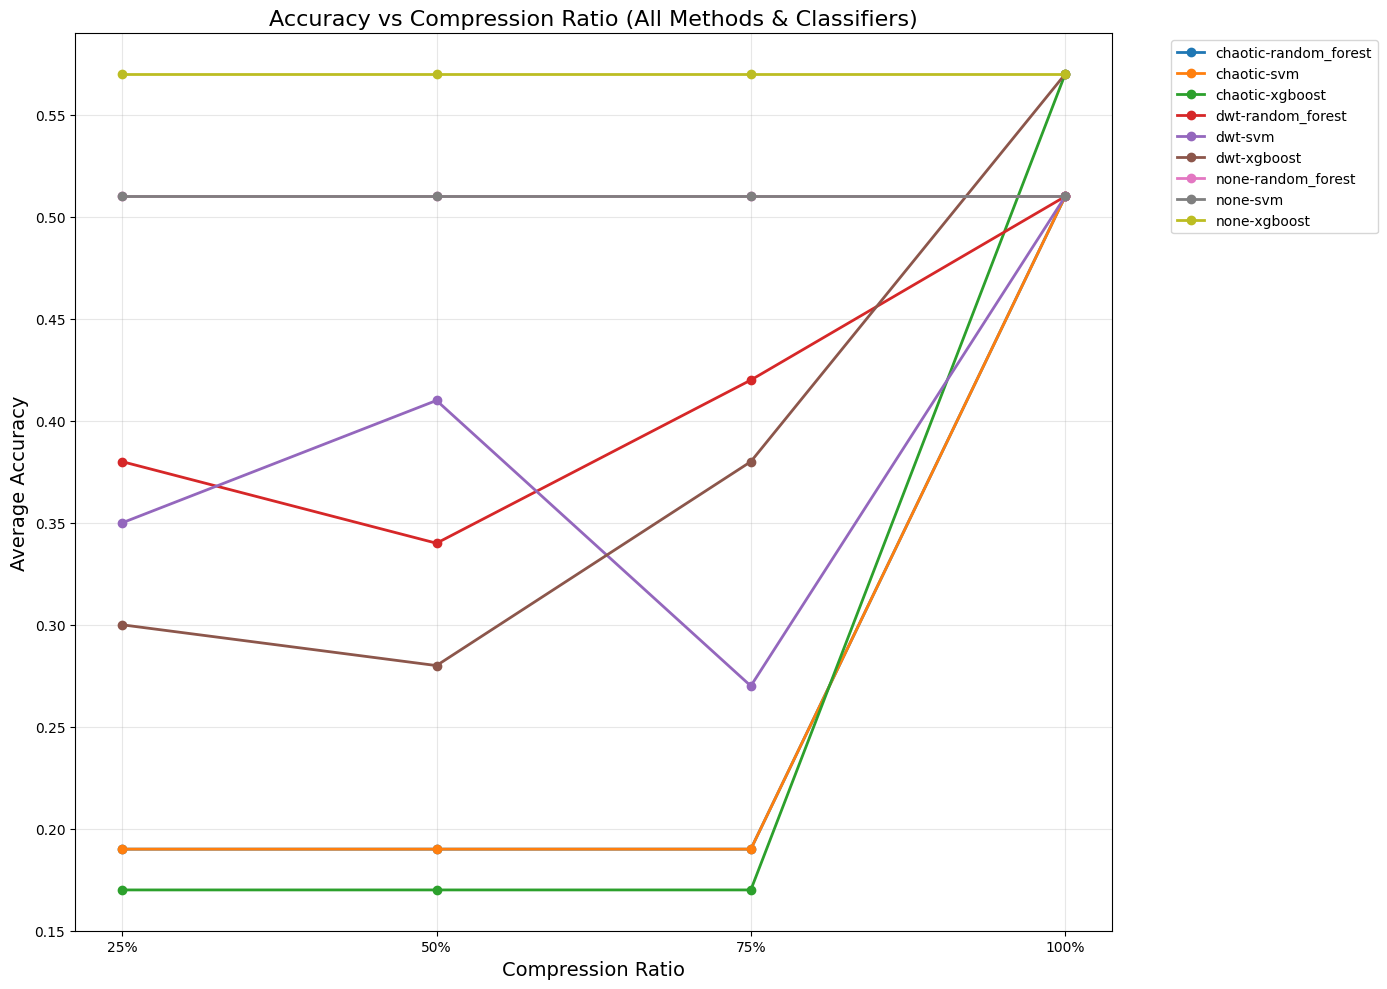

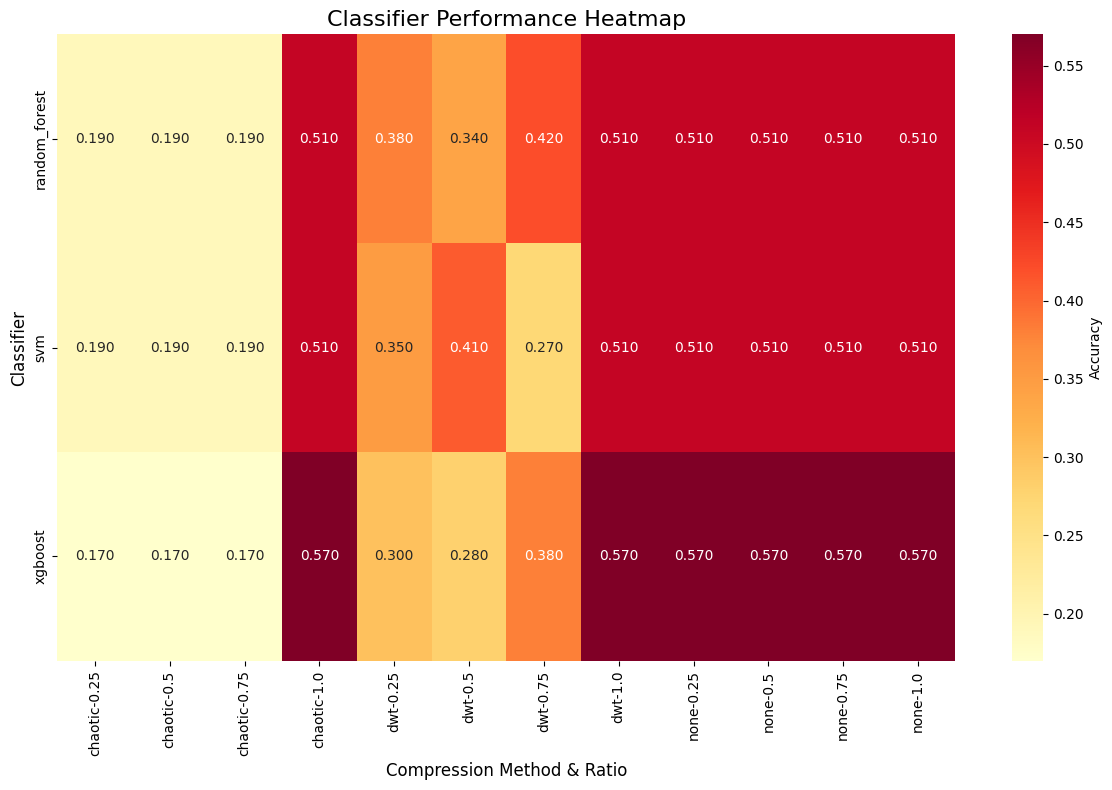

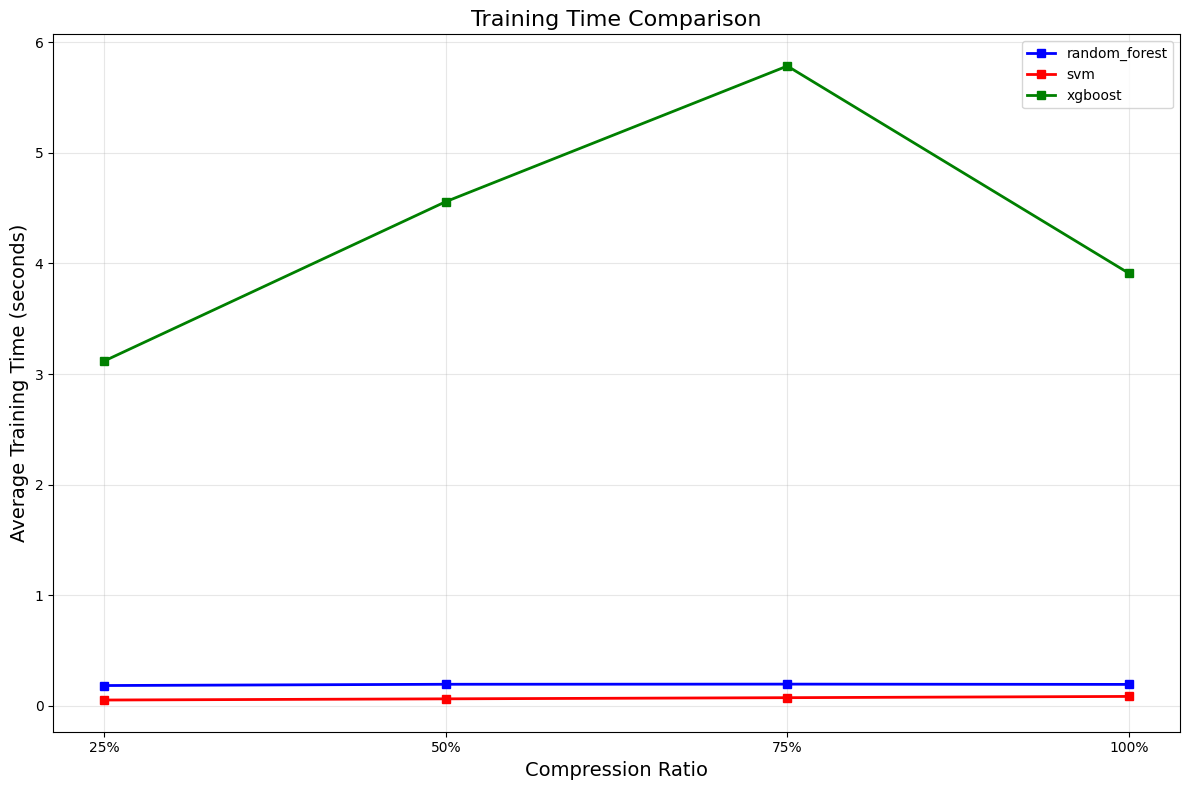

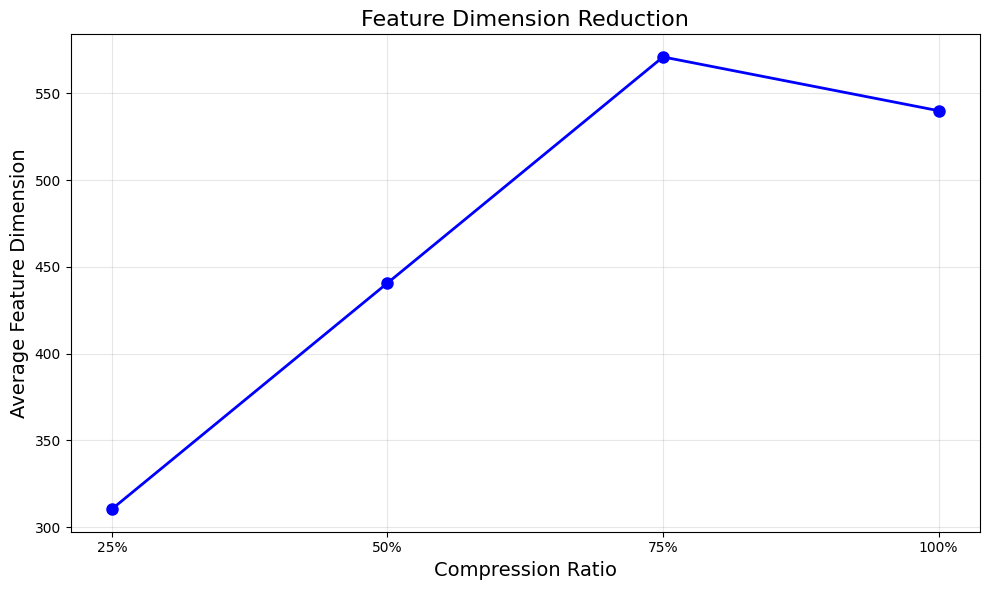

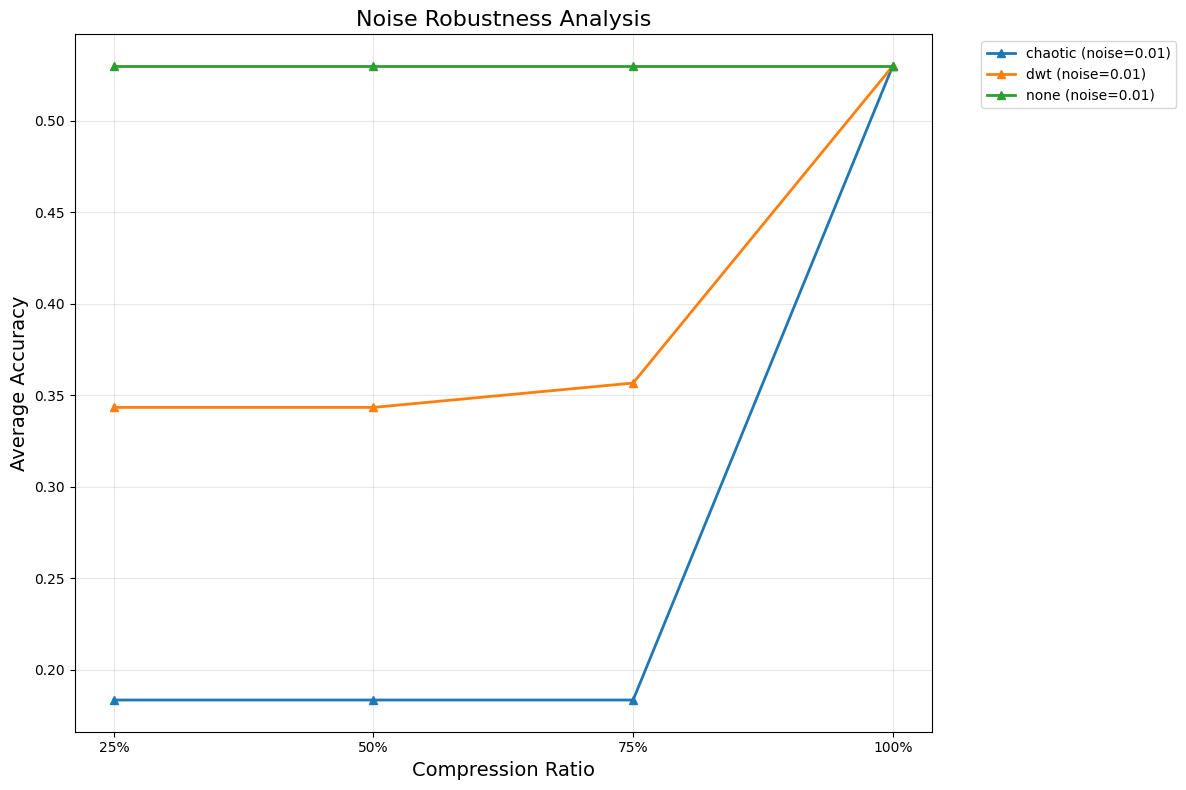


Full experiment completed! Check 'complete_chaotic_results' folder.

MAIN MENU
1. Demo Chaotic Compression (Single File)
2. Test Single File Classification
3. Run Sample Test (Small Scale)
4. Run Full Experiment (All Models)
5. View Previous Results
6. Exit
------------------------------------------------------------



Enter your choice (1-6):  5



Available results in 'complete_chaotic_results':
------------------------------------------------------------

CSV Files:
  - full_experiment_results.csv

JSON Files:
  - experiment_summary.json

EXPERIMENT SUMMARY
Experiment Date: 2025-12-17 10:42:16
Total Experiments: 72

Overall Best Result:
  Method: chaotic
  Ratio: 1.0
  Classifier: xgboost
  Accuracy: 0.5700
  F1 Score: 0.5061

MAIN MENU
1. Demo Chaotic Compression (Single File)
2. Test Single File Classification
3. Run Sample Test (Small Scale)
4. Run Full Experiment (All Models)
5. View Previous Results
6. Exit
------------------------------------------------------------



Enter your choice (1-6):  6



Thank you for using the Chaotic Compression Experiment System!
Goodbye!


In [3]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.fft import dct, idct
from scipy.sparse.linalg import lsqr
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, accuracy_score, precision_score, 
                           recall_score, f1_score)
import warnings
from tqdm import tqdm
import pickle
import json
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# ============================================
# 1. Enhanced Feature Extraction (Base Class)
# ============================================

class RobustMFCCExtractor:
    """
    Enhanced MFCC feature extraction with multiple robust techniques
    """
    
    def __init__(self, sr=22050, n_mfcc=40, n_fft=2048, hop_length=512):
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
    def extract_mfcc_features(self, audio_path):
        """
        Extract comprehensive MFCC-based features
        """
        try:
            # Load audio
            y, sr = librosa.load(audio_path, sr=self.sr, duration=3.0)
            
            # Zero-padding or truncation for consistent length
            target_length = self.sr * 3  # 3 seconds
            if len(y) < target_length:
                y = np.pad(y, (0, target_length - len(y)), mode='constant')
            else:
                y = y[:target_length]
            
            # Apply pre-emphasis filter
            y = librosa.effects.preemphasis(y)
            
            # Extract base MFCCs
            mfccs = librosa.feature.mfcc(
                y=y, 
                sr=sr, 
                n_mfcc=self.n_mfcc,
                n_fft=self.n_fft,
                hop_length=self.hop_length
            )
            
            # Extract delta and delta-delta features
            mfcc_delta = librosa.feature.delta(mfccs)
            mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
            
            # Extract other complementary features
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
            spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=self.hop_length)
            
            # Root Mean Square Energy
            rms = librosa.feature.rms(y=y, hop_length=self.hop_length)
            
            # Zero Crossing Rate
            zcr = librosa.feature.zero_crossing_rate(y, hop_length=self.hop_length)
            
            # Spectral Centroid and Rolloff
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=self.hop_length)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=self.hop_length)
            
            # Combine all features
            features = np.vstack([
                mfccs,
                mfcc_delta,
                mfcc_delta2,
                chroma,
                spectral_contrast,
                rms,
                zcr,
                spectral_centroid,
                spectral_rolloff
            ])
            
            # Extract statistical features
            feature_stats = self._extract_statistics(features)
            
            return feature_stats
            
        except Exception as e:
            print(f"Error processing {audio_path}: {str(e)}")
            return np.zeros(1200)  # Fixed dimension
    
    def _extract_statistics(self, features):
        """
        Extract statistical features from feature matrix
        """
        stats = []
        for feature in features:
            stats.extend([
                np.mean(feature),
                np.std(feature),
                np.median(feature),
                np.min(feature),
                np.max(feature),
                np.percentile(feature, 25),
                np.percentile(feature, 75),
                np.mean(np.diff(feature)),  # Average change
                np.std(np.diff(feature))    # Std of changes
            ])
        return np.array(stats)
    
    def extract_all_features(self, audio_paths, labels=None):
        """
        Extract features from multiple audio files
        """
        features = []
        valid_labels = []
        
        for idx, path in enumerate(tqdm(audio_paths, desc="Extracting features")):
            feat = self.extract_mfcc_features(path)
            if np.sum(feat) != 0 and not np.isnan(feat).any():  # Skip zero or NaN features
                features.append(feat)
                if labels is not None:
                    valid_labels.append(labels[idx])
        
        if len(features) == 0:
            print("WARNING: No valid features extracted!")
            return np.array([]), np.array([])
        
        features = np.array(features)
        
        # Normalize features
        features = self.scaler.fit_transform(features)
        
        # Encode labels if provided
        if labels is not None and len(valid_labels) > 0:
            encoded_labels = self.label_encoder.fit_transform(valid_labels)
        else:
            encoded_labels = None
        
        return features, encoded_labels

# ============================================
# 2. UrbanSound8K Processor
# ============================================

class UrbanSound8KProcessor:
    """
    Process UrbanSound8K dataset
    """
    
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.metadata_path = os.path.join(dataset_path, 'metadata', 'UrbanSound8K.csv')
        if not os.path.exists(self.metadata_path):
            # Try alternative path structure
            self.metadata_path = os.path.join(dataset_path, 'UrbanSound8K.csv')
        
        if not os.path.exists(self.metadata_path):
            raise FileNotFoundError(f"Metadata file not found at {self.metadata_path}")
        
        self.metadata = pd.read_csv(self.metadata_path)
        
    def prepare_data(self, folds=None):
        """
        Prepare data for specific folds or all folds
        """
        if folds is None:
            folds = list(range(1, 11))
        elif isinstance(folds, int):
            folds = [folds]
        
        audio_paths = []
        labels = []
        fold_numbers = []
        
        for fold in folds:
            fold_data = self.metadata[self.metadata['fold'] == fold]
            
            for _, row in fold_data.iterrows():
                # Try different possible paths
                possible_paths = [
                    os.path.join(self.dataset_path, 'fold' + str(row['fold']), row['slice_file_name']),
                    os.path.join(self.dataset_path, 'audio', 'fold' + str(row['fold']), row['slice_file_name']),
                    os.path.join(self.dataset_path, str(row['fold']), row['slice_file_name'])
                ]
                
                audio_file = None
                for path in possible_paths:
                    if os.path.exists(path):
                        audio_file = path
                        break
                
                if audio_file:
                    audio_paths.append(audio_file)
                    labels.append(row['class'])
                    fold_numbers.append(fold)
                else:
                    print(f"WARNING: File not found: {row['slice_file_name']} in fold {fold}")
        
        print(f"Found {len(audio_paths)} valid audio files out of {len(fold_data) * len(folds)} expected")
        return audio_paths, labels, fold_numbers
    
    def get_class_distribution(self):
        """
        Get class distribution statistics
        """
        return self.metadata['class'].value_counts()
    
    def get_sample_files(self, n_samples=10, random_state=42):
        """
        Get a sample of files for testing
        """
        np.random.seed(random_state)
        sample_indices = np.random.choice(len(self.metadata), min(n_samples, len(self.metadata)), replace=False)
        
        audio_paths = []
        labels = []
        
        for idx in sample_indices:
            row = self.metadata.iloc[idx]
            audio_file = os.path.join(self.dataset_path, 'fold' + str(row['fold']), row['slice_file_name'])
            
            if os.path.exists(audio_file):
                audio_paths.append(audio_file)
                labels.append(row['class'])
            else:
                # Try alternative path
                audio_file = os.path.join(self.dataset_path, 'audio', 'fold' + str(row['fold']), row['slice_file_name'])
                if os.path.exists(audio_file):
                    audio_paths.append(audio_file)
                    labels.append(row['class'])
        
        return audio_paths, labels

# ============================================
# 3. Optimized Chaotic Compression Modules
# ============================================

class FastLogisticHenonCompressor:
    """
    Fast Logistic-Henon Hybrid Chaotic Map Compressor
    """
    
    def __init__(self, compression_ratio=0.5, seed=42, noise_level=0.0, 
                 logistic_r=3.99, henon_a=1.4, henon_b=0.3):
        """
        Initialize Logistic-Henon chaotic compressor
        """
        self.compression_ratio = compression_ratio
        self.seed = seed
        self.noise_level = noise_level
        self.logistic_r = logistic_r
        self.henon_a = henon_a
        self.henon_b = henon_b
        self.measurement_matrix = None
        self.chaotic_properties = {}
        np.random.seed(self.seed)
        
    def generate_chaotic_sequence(self, n_elements):
        """
        Generate chaotic sequence using optimized loops
        """
        # Burn-in period
        x = np.random.rand()
        y = np.random.rand()
        
        for _ in range(1000):
            logistic = self.logistic_r * x * (1 - x)
            x_henon = 1 - self.henon_a * x**2 + y
            y = self.henon_b * x
            x = 0.7 * logistic + 0.3 * x_henon
            x = np.clip(x, -2, 2)
        
        # Generate sequence
        sequence = np.zeros(n_elements)
        for i in range(n_elements):
            logistic = self.logistic_r * x * (1 - x)
            x_henon = 1 - self.henon_a * x**2 + y
            y = self.henon_b * x
            x = 0.7 * logistic + 0.3 * x_henon
            x = np.clip(x, -2, 2)
            sequence[i] = x
        
        return sequence
    
    def generate_chaotic_matrix(self, n_original, n_compressed):
        """
        Generate measurement matrix using chaotic sequence
        """
        total_elements = n_original * n_compressed
        
        # Generate chaotic sequence
        chaotic_seq = self.generate_chaotic_sequence(total_elements)
        
        # Reshape to matrix form
        chaotic_matrix = chaotic_seq.reshape(n_compressed, n_original)
        
        # Normalize columns
        norms = np.linalg.norm(chaotic_matrix, axis=0)
        norms[norms == 0] = 1
        chaotic_matrix = chaotic_matrix / norms
        
        # Store properties
        self.chaotic_properties = {
            'mean': np.mean(chaotic_seq),
            'std': np.std(chaotic_seq),
            'min': np.min(chaotic_seq),
            'max': np.max(chaotic_seq),
            'entropy': self.calculate_entropy(chaotic_seq)
        }
        
        return chaotic_matrix
    
    def calculate_entropy(self, sequence, bins=50):
        """
        Calculate Shannon entropy
        """
        hist, _ = np.histogram(sequence, bins=bins, density=True)
        hist = hist[hist > 0]
        return -np.sum(hist * np.log(hist))
    
    def compress(self, signal, precomputed_matrix=None):
        """
        Compress signal using chaotic matrix
        """
        n_original = len(signal)
        n_compressed = int(n_original * self.compression_ratio)
        n_compressed = max(1, n_compressed)
        
        # Use precomputed or generate new matrix
        if precomputed_matrix is not None:
            self.measurement_matrix = precomputed_matrix
        elif self.measurement_matrix is None or self.measurement_matrix.shape != (n_compressed, n_original):
            self.measurement_matrix = self.generate_chaotic_matrix(n_original, n_compressed)
        
        # Compress signal
        compressed_signal = np.dot(self.measurement_matrix, signal)
        
        # Add noise if specified
        if self.noise_level > 0:
            noise = np.random.randn(n_compressed) * self.noise_level
            compressed_signal += noise
        
        return compressed_signal
    
    def reconstruct_omp(self, compressed_signal, sparsity_level=None, max_iter=30):
        """
        Fast OMP reconstruction
        """
        if self.measurement_matrix is None:
            raise ValueError("Measurement matrix not created.")
        
        if sparsity_level is None:
            sparsity_level = min(20, len(compressed_signal) // 2)
        
        m, n = self.measurement_matrix.shape
        residual = compressed_signal.copy()
        support = []
        reconstructed_signal = np.zeros(n)
        
        for _ in range(min(sparsity_level, max_iter)):
            correlations = np.abs(self.measurement_matrix.T @ residual)
            correlations[support] = -np.inf
            new_idx = np.argmax(correlations)
            support.append(new_idx)
            
            A_support = self.measurement_matrix[:, support]
            x_support = np.linalg.lstsq(A_support, compressed_signal, rcond=None)[0]
            
            residual = compressed_signal - A_support @ x_support
            
            if np.linalg.norm(residual) < 1e-4:
                break
        
        reconstructed_signal[support] = x_support[:len(support)]
        return reconstructed_signal

class FastDWTCompressor:
    """Fast DWT Compression"""
    
    def __init__(self, compression_ratio=0.5):
        self.compression_ratio = compression_ratio
        
    def haar_transform(self, signal):
        """
        Fast Haar transform
        """
        n = len(signal)
        # Ensure power of 2
        n_pow2 = 1 << (n-1).bit_length()
        if n_pow2 != n:
            signal = np.pad(signal, (0, n_pow2 - n), 'constant')
            n = n_pow2
        
        coeffs = signal.copy().astype(float)
        step = n
        
        while step > 1:
            half = step // 2
            for i in range(half):
                avg = (coeffs[2*i] + coeffs[2*i+1]) / np.sqrt(2)
                diff = (coeffs[2*i] - coeffs[2*i+1]) / np.sqrt(2)
                coeffs[i] = avg
                coeffs[half + i] = diff
            step = half
            
        return coeffs
    
    def inverse_haar_transform(self, coeffs):
        """
        Fast inverse Haar transform
        """
        n = len(coeffs)
        signal = coeffs.copy()
        step = 2
        
        while step <= n:
            half = step // 2
            temp = signal.copy()
            for i in range(half):
                signal[2*i] = (temp[i] + temp[half + i]) / np.sqrt(2)
                signal[2*i+1] = (temp[i] - temp[half + i]) / np.sqrt(2)
            step *= 2
            
        return signal
    
    def compress(self, signal):
        """
        Compress using thresholding
        """
        coeffs = self.haar_transform(signal)
        n_coeffs = len(coeffs)
        n_keep = int(n_coeffs * self.compression_ratio)
        
        indices = np.argsort(np.abs(coeffs))[-n_keep:]
        mask = np.zeros(n_coeffs, dtype=bool)
        mask[indices] = True
        
        compressed_coeffs = np.zeros_like(coeffs)
        compressed_coeffs[indices] = coeffs[indices]
        
        return compressed_coeffs, mask

# ============================================
# 4. Feature Extraction with Compression
# ============================================

class ChaoticFeatureExtractor:
    """
    Feature extractor with chaotic compression
    """
    
    def __init__(self, sr=22050, n_mfcc=30, n_fft=1024, hop_length=512):
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.n_fft = n_fft
        self.hop_length = hop_length
        
    def extract_features(self, audio_path):
        """
        Extract MFCC features from audio file
        """
        try:
            # Load audio
            y, sr = librosa.load(audio_path, sr=self.sr, duration=3.0)
            
            # Ensure consistent length
            target_length = self.sr * 3
            if len(y) < target_length:
                y = np.pad(y, (0, target_length - len(y)), mode='constant')
            else:
                y = y[:target_length]
            
            # Extract features
            mfccs = librosa.feature.mfcc(
                y=y, 
                sr=sr, 
                n_mfcc=self.n_mfcc,
                n_fft=self.n_fft,
                hop_length=self.hop_length
            )
            
            mfcc_delta = librosa.feature.delta(mfccs)
            mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
            
            # Combine features
            features = np.vstack([mfccs, mfcc_delta, mfcc_delta2])
            
            # Extract statistics
            stats = []
            for feature in features:
                stats.extend([
                    np.mean(feature),
                    np.std(feature),
                    np.min(feature),
                    np.max(feature),
                    np.percentile(feature, 25),
                    np.percentile(feature, 75)
                ])
            
            return np.array(stats)
            
        except Exception as e:
            print(f"Error processing {audio_path}: {str(e)}")
            return np.zeros(180)  # 30 mfcc * 6 stats * 3 (mfcc + delta + delta2)
    
    def extract_with_compression(self, audio_path, compression_method='chaotic', 
                                 compression_ratio=0.5, noise_level=0.0,
                                 precomputed_matrix=None):
        """
        Extract features with optional compression
        """
        # Extract original features
        original_features = self.extract_features(audio_path)
        
        if compression_method == 'none' or compression_ratio >= 1.0:
            return original_features, original_features, {'method': 'none', 'ratio': 1.0}
        
        features_1d = original_features.flatten()
        
        compression_info = {
            'method': compression_method,
            'ratio': compression_ratio,
            'original_length': len(features_1d),
            'compressed_length': int(len(features_1d) * compression_ratio),
            'noise_level': noise_level
        }
        
        # Apply compression
        if compression_method == 'chaotic':
            compressor = FastLogisticHenonCompressor(
                compression_ratio=compression_ratio, 
                noise_level=noise_level
            )
            compressed_features = compressor.compress(features_1d, precomputed_matrix)
            compression_info['compressor'] = compressor
            compression_info['chaotic_properties'] = compressor.chaotic_properties
            
        elif compression_method == 'dwt':
            compressor = FastDWTCompressor(compression_ratio=compression_ratio)
            compressed_coeffs, mask = compressor.compress(features_1d)
            compressed_features = compressed_coeffs[mask]
            compression_info['compressor'] = compressor
            
        else:
            # For hybrid, use chaotic
            compressor = FastLogisticHenonCompressor(
                compression_ratio=compression_ratio, 
                noise_level=noise_level
            )
            compressed_features = compressor.compress(features_1d, precomputed_matrix)
            compression_info['compressor'] = compressor
        
        return compressed_features, original_features, compression_info

# ============================================
# 5. Complete Experiment Pipeline
# ============================================

class CompleteChaoticCompressionExperiment:
    """
    Complete experiment with all models and options
    """
    
    def __init__(self, dataset_path, output_dir='complete_chaotic_results'):
        self.dataset_path = dataset_path
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
        # Experiment configurations
        self.compression_methods = ['chaotic', 'dwt', 'none']
        self.compression_ratios = [0.25, 0.5, 0.75, 1.0]
        self.noise_levels = [0.0, 0.01]
        
        # All three classifiers
        self.classifiers = {
            'random_forest': RandomForestClassifier(
                n_estimators=100, 
                random_state=42, 
                n_jobs=-1,
                max_depth=10
            ),
            'svm': SVC(
                probability=True, 
                random_state=42,
                kernel='rbf',
                C=1.0,
                gamma='scale'
            ),
            'xgboost': XGBClassifier(
                n_estimators=100,
                random_state=42,
                n_jobs=-1,
                max_depth=6,
                learning_rate=0.1
            )
        }
        
        # Cache for pre-generated matrices
        self.chaotic_matrices_cache = {}
        
    def run_test_with_sample_files(self, n_samples=50):
        """
        Test with a small sample of files first
        """
        print("="*70)
        print("TESTING WITH SAMPLE FILES")
        print("="*70)
        
        processor = UrbanSound8KProcessor(self.dataset_path)
        extractor = ChaoticFeatureExtractor()
        
        # Get sample files
        print(f"\nGetting {n_samples} sample files...")
        sample_paths, sample_labels = processor.get_sample_files(n_samples=n_samples)
        
        if len(sample_paths) == 0:
            print("ERROR: No sample files found!")
            return
        
        print(f"Found {len(sample_paths)} sample files")
        
        # Test different compression methods
        results = []
        
        for method in ['chaotic', 'dwt', 'none']:
            print(f"\nTesting {method.upper()} compression...")
            
            for ratio in [0.5, 0.75]:
                print(f"  Ratio: {ratio*100:.0f}%")
                
                # Extract features
                features_list = []
                labels_list = []
                
                for path, label in tqdm(zip(sample_paths, sample_labels), 
                                       total=len(sample_paths), 
                                       desc=f"Processing {method}"):
                    try:
                        compressed_feat, _, _ = extractor.extract_with_compression(
                            path, method, ratio, 0.0
                        )
                        features_list.append(compressed_feat)
                        labels_list.append(label)
                    except Exception as e:
                        print(f"Error with {path}: {e}")
                        continue
                
                if len(features_list) == 0:
                    print("    No features extracted!")
                    continue
                
                # Pad features to same length
                max_len = max(len(f) for f in features_list)
                features_padded = np.array([np.pad(f, (0, max_len - len(f)), 'constant') 
                                           for f in features_list])
                
                # Encode labels
                label_encoder = LabelEncoder()
                y = label_encoder.fit_transform(labels_list)
                
                # Split data
                X_train, X_test, y_train, y_test = train_test_split(
                    features_padded, y, test_size=0.3, random_state=42, stratify=y
                )
                
                # Normalize
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                
                # Train and test each classifier
                for clf_name, clf in self.classifiers.items():
                    print(f"    Training {clf_name}...")
                    
                    start_time = time.time()
                    clf.fit(X_train_scaled, y_train)
                    train_time = time.time() - start_time
                    
                    start_time = time.time()
                    y_pred = clf.predict(X_test_scaled)
                    test_time = time.time() - start_time
                    
                    accuracy = accuracy_score(y_test, y_pred)
                    f1 = f1_score(y_test, y_pred, average='weighted')
                    
                    result = {
                        'method': method,
                        'ratio': ratio,
                        'classifier': clf_name,
                        'accuracy': accuracy,
                        'f1_score': f1,
                        'train_time': train_time,
                        'test_time': test_time,
                        'n_samples': len(features_list)
                    }
                    
                    results.append(result)
                    
                    print(f"      Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Train time: {train_time:.2f}s")
        
        # Save test results
        test_results_df = pd.DataFrame(results)
        test_results_df.to_csv(os.path.join(self.output_dir, 'sample_test_results.csv'), index=False)
        
        # Generate test report
        self.generate_test_report(test_results_df)
        
        return test_results_df
    
    def run_full_experiment(self, train_folds=[1, 2, 3, 4, 5, 6, 7, 8], 
                           test_folds=[9, 10], max_files_per_fold=100):
        """
        Run full experiment with all models
        """
        print("="*70)
        print("FULL CHAOTIC COMPRESSION EXPERIMENT")
        print("="*70)
        
        processor = UrbanSound8KProcessor(self.dataset_path)
        extractor = ChaoticFeatureExtractor()
        
        # Prepare data
        print("\nPreparing data...")
        train_paths, train_labels, _ = processor.prepare_data(train_folds)
        test_paths, test_labels, _ = processor.prepare_data(test_folds)
        
        # Limit files for speed
        if max_files_per_fold:
            print(f"Limiting to {max_files_per_fold} files per fold...")
            
            # Function to limit files while maintaining class balance
            def limit_files(paths, labels, max_per_class=20):
                df = pd.DataFrame({'path': paths, 'label': labels})
                limited_df = df.groupby('label').head(max_per_class)
                return limited_df['path'].tolist(), limited_df['label'].tolist()
            
            train_paths, train_labels = limit_files(train_paths, train_labels, max_per_class=20)
            test_paths, test_labels = limit_files(test_paths, test_labels, max_per_class=10)
        
        print(f"Training: {len(train_paths)} files, Testing: {len(test_paths)} files")
        
        # Encode labels
        label_encoder = LabelEncoder()
        y_train_full = label_encoder.fit_transform(train_labels)
        y_test_full = label_encoder.transform(test_labels)
        
        # Store all results
        all_results = []
        
        # Pre-generate chaotic matrices
        print("\nPre-generating chaotic matrices...")
        sample_feat = extractor.extract_features(train_paths[0])
        feature_dim = len(sample_feat)
        
        for ratio in self.compression_ratios:
            if ratio < 1.0:
                n_compressed = int(feature_dim * ratio)
                compressor = FastLogisticHenonCompressor(compression_ratio=ratio)
                matrix = compressor.generate_chaotic_matrix(feature_dim, n_compressed)
                self.chaotic_matrices_cache[ratio] = matrix
                print(f"  Generated matrix for ratio {ratio}: {matrix.shape}")
        
        # Run experiments
        for method in self.compression_methods:
            print(f"\n{'='*60}")
            print(f"Compression Method: {method.upper()}")
            print('='*60)
            
            for ratio in self.compression_ratios:
                for noise_level in self.noise_levels:
                    print(f"\nCompression Ratio: {ratio*100:.0f}%, Noise: {noise_level}")
                    print("-"*40)
                    
                    # Get precomputed matrix
                    precomputed_matrix = self.chaotic_matrices_cache.get(ratio) if method == 'chaotic' and ratio < 1.0 else None
                    
                    # Extract features
                    X_train = []
                    X_test = []
                    
                    print("Processing training data...")
                    for path in tqdm(train_paths, desc=f"Train {method}"):
                        compressed_feat, _, _ = extractor.extract_with_compression(
                            path, method, ratio, noise_level, precomputed_matrix
                        )
                        X_train.append(compressed_feat)
                    
                    print("Processing test data...")
                    for path in tqdm(test_paths, desc=f"Test {method}"):
                        compressed_feat, _, _ = extractor.extract_with_compression(
                            path, method, ratio, noise_level, precomputed_matrix
                        )
                        X_test.append(compressed_feat)
                    
                    # Pad features
                    max_len = max(
                        max([len(x) for x in X_train]) if X_train else 0,
                        max([len(x) for x in X_test]) if X_test else 0
                    )
                    
                    X_train_padded = np.array([np.pad(x, (0, max_len - len(x)), 'constant') 
                                              for x in X_train])
                    X_test_padded = np.array([np.pad(x, (0, max_len - len(x)), 'constant') 
                                             for x in X_test])
                    
                    # Normalize
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train_padded)
                    X_test_scaled = scaler.transform(X_test_padded)
                    
                    # Train and evaluate each classifier
                    for clf_name, clf in self.classifiers.items():
                        print(f"  Training {clf_name}...")
                        
                        # Train
                        start_time = time.time()
                        clf.fit(X_train_scaled, y_train_full)
                        train_time = time.time() - start_time
                        
                        # Predict
                        start_time = time.time()
                        y_pred = clf.predict(X_test_scaled)
                        y_proba = clf.predict_proba(X_test_scaled) if hasattr(clf, 'predict_proba') else None
                        test_time = time.time() - start_time
                        
                        # Calculate metrics
                        accuracy = accuracy_score(y_test_full, y_pred)
                        precision = precision_score(y_test_full, y_pred, average='weighted')
                        recall = recall_score(y_test_full, y_pred, average='weighted')
                        f1 = f1_score(y_test_full, y_pred, average='weighted')
                        
                        # ROC-AUC
                        try:
                            if y_proba is not None:
                                roc_auc = roc_auc_score(y_test_full, y_proba, multi_class='ovr', average='weighted')
                            else:
                                roc_auc = np.nan
                        except:
                            roc_auc = np.nan
                        
                        # Confusion matrix
                        cm = confusion_matrix(y_test_full, y_pred)
                        
                        # Save model
                        model_filename = f"{method}_{ratio}_{noise_level}_{clf_name}.pkl"
                        model_path = os.path.join(self.output_dir, 'models', model_filename)
                        os.makedirs(os.path.dirname(model_path), exist_ok=True)
                        
                        with open(model_path, 'wb') as f:
                            pickle.dump(clf, f)
                        
                        # Store results
                        result = {
                            'compression_method': method,
                            'compression_ratio': ratio,
                            'noise_level': noise_level,
                            'classifier': clf_name,
                            'accuracy': accuracy,
                            'precision': precision,
                            'recall': recall,
                            'f1_score': f1,
                            'roc_auc': roc_auc,
                            'train_time': train_time,
                            'test_time': test_time,
                            'feature_dim': X_train_scaled.shape[1],
                            'compression_rate': (1 - ratio) * 100 if ratio < 1.0 else 0,
                            'n_train_samples': len(X_train),
                            'n_test_samples': len(X_test),
                            'model_file': model_filename,
                            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                        }
                        
                        all_results.append(result)
                        
                        # Print confusion matrix
                        print(f"    Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
                        print(f"    Train time: {train_time:.2f}s, Test time: {test_time:.2f}s")
                        
                        # Save confusion matrix plot
                        self.plot_confusion_matrix(cm, label_encoder.classes_, 
                                                  method, ratio, noise_level, clf_name)
        
        # Save all results
        self.save_full_results(all_results)
        
        # Generate comprehensive report
        self.generate_full_report(all_results, label_encoder)
        
        return all_results
    
    def plot_confusion_matrix(self, cm, classes, method, ratio, noise, classifier):
        """
        Plot and save confusion matrix
        """
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix: {method} (Ratio: {ratio}, Noise: {noise})\n{classifier}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        
        filename = f"cm_{method}_{ratio}_{noise}_{classifier}.png"
        filepath = os.path.join(self.output_dir, 'confusion_matrices', filename)
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close()
    
    def save_full_results(self, all_results):
        """
        Save all experiment results
        """
        # Save results as CSV
        results_df = pd.DataFrame(all_results)
        results_df.to_csv(os.path.join(self.output_dir, 'full_experiment_results.csv'), index=False)
        
        # Save summary statistics
        summary = {
            'experiment_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'total_experiments': len(all_results),
            'compression_methods': list(results_df['compression_method'].unique()),
            'compression_ratios': list(results_df['compression_ratio'].unique()),
            'noise_levels': list(results_df['noise_level'].unique()),
            'classifiers': list(results_df['classifier'].unique()),
            'best_results': {}
        }
        
        # Find best results for each method
        for method in summary['compression_methods']:
            method_df = results_df[results_df['compression_method'] == method]
            if not method_df.empty:
                best_idx = method_df['accuracy'].idxmax()
                summary['best_results'][method] = method_df.loc[best_idx].to_dict()
        
        # Overall best
        if not results_df.empty:
            best_idx = results_df['accuracy'].idxmax()
            summary['overall_best'] = results_df.loc[best_idx].to_dict()
        
        with open(os.path.join(self.output_dir, 'experiment_summary.json'), 'w') as f:
            json.dump(summary, f, indent=2)
        
        print(f"\nResults saved to {self.output_dir}/")
    
    def generate_test_report(self, test_results_df):
        """
        Generate test report
        """
        if test_results_df.empty:
            return
        
        print("\n" + "="*70)
        print("SAMPLE TEST REPORT")
        print("="*70)
        
        # Display results table
        print("\nTest Results Summary:")
        print("-"*80)
        print(f"{'Method':<10} {'Ratio':<8} {'Classifier':<15} {'Accuracy':<10} {'F1 Score':<10} {'Train Time':<12}")
        print("-"*80)
        
        for _, row in test_results_df.iterrows():
            print(f"{row['method']:<10} "
                  f"{row['ratio']:<8.2f} "
                  f"{row['classifier']:<15} "
                  f"{row['accuracy']:<10.4f} "
                  f"{row['f1_score']:<10.4f} "
                  f"{row['train_time']:<10.2f}s")
        
        # Plot results
        plt.figure(figsize=(12, 8))
        
        for clf in test_results_df['classifier'].unique():
            clf_df = test_results_df[test_results_df['classifier'] == clf]
            for method in clf_df['method'].unique():
                method_df = clf_df[clf_df['method'] == method]
                if not method_df.empty:
                    plt.plot(method_df['ratio'], method_df['accuracy'], 
                            marker='o', linewidth=2, label=f'{method}-{clf}')
        
        plt.xlabel('Compression Ratio', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title('Sample Test: Accuracy vs Compression Ratio', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks([0.5, 0.75, 1.0], ['50%', '75%', '100%'])
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'sample_test_results.png'), 
                   dpi=150, bbox_inches='tight')
        plt.show()
    
    def generate_full_report(self, all_results, label_encoder):
        """
        Generate comprehensive report
        """
        results_df = pd.DataFrame(all_results)
        
        if results_df.empty:
            return
        
        print("\n" + "="*70)
        print("FULL EXPERIMENT REPORT")
        print("="*70)
        
        # 1. Summary table
        print("\nOverall Best Results:")
        print("-"*100)
        print(f"{'Method':<10} {'Ratio':<8} {'Noise':<8} {'Classifier':<15} {'Accuracy':<10} {'F1':<10} {'Dim':<8} {'Comp Rate':<10}")
        print("-"*100)
        
        # Sort by accuracy
        sorted_df = results_df.sort_values('accuracy', ascending=False).head(10)
        
        for _, row in sorted_df.iterrows():
            print(f"{row['compression_method']:<10} "
                  f"{row['compression_ratio']:<8.2f} "
                  f"{row['noise_level']:<8.3f} "
                  f"{row['classifier']:<15} "
                  f"{row['accuracy']:<10.4f} "
                  f"{row['f1_score']:<10.4f} "
                  f"{int(row['feature_dim']):<8} "
                  f"{row['compression_rate']:<9.1f}%")
        
        # 2. Visualizations
        self.create_visualizations(results_df, label_encoder)
    
    def create_visualizations(self, results_df, label_encoder):
        """
        Create comprehensive visualizations
        """
        # Create plots directory
        plots_dir = os.path.join(self.output_dir, 'plots')
        os.makedirs(plots_dir, exist_ok=True)
        
        # 1. Accuracy vs Compression Ratio for each method
        plt.figure(figsize=(14, 10))
        
        for method in results_df['compression_method'].unique():
            method_df = results_df[results_df['compression_method'] == method]
            for clf in method_df['classifier'].unique():
                clf_df = method_df[method_df['classifier'] == clf]
                if not clf_df.empty:
                    # Group by ratio and get mean accuracy
                    grouped = clf_df.groupby('compression_ratio')['accuracy'].mean()
                    plt.plot(grouped.index, grouped.values, 
                            marker='o', linewidth=2, label=f'{method}-{clf}')
        
        plt.xlabel('Compression Ratio', fontsize=14)
        plt.ylabel('Average Accuracy', fontsize=14)
        plt.title('Accuracy vs Compression Ratio (All Methods & Classifiers)', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks([0.25, 0.5, 0.75, 1.0], ['25%', '50%', '75%', '100%'])
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'accuracy_vs_ratio_all.png'), 
                   dpi=150, bbox_inches='tight')
        plt.show()
        
        # 2. Classifier comparison heatmap
        plt.figure(figsize=(12, 8))
        
        # Create pivot table
        pivot_table = results_df.pivot_table(
            values='accuracy',
            index='classifier',
            columns=['compression_method', 'compression_ratio'],
            aggfunc='mean'
        )
        
        sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', 
                   cbar_kws={'label': 'Accuracy'})
        plt.title('Classifier Performance Heatmap', fontsize=16)
        plt.xlabel('Compression Method & Ratio', fontsize=12)
        plt.ylabel('Classifier', fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'classifier_heatmap.png'), 
                   dpi=150, bbox_inches='tight')
        plt.show()
        
        # 3. Training time comparison
        plt.figure(figsize=(12, 8))
        
        colors = {'random_forest': 'blue', 'svm': 'red', 'xgboost': 'green'}
        
        for clf in results_df['classifier'].unique():
            clf_df = results_df[results_df['classifier'] == clf]
            if not clf_df.empty:
                grouped = clf_df.groupby('compression_ratio')['train_time'].mean()
                plt.plot(grouped.index, grouped.values, 
                        marker='s', linewidth=2, color=colors.get(clf, 'gray'),
                        label=clf)
        
        plt.xlabel('Compression Ratio', fontsize=14)
        plt.ylabel('Average Training Time (seconds)', fontsize=14)
        plt.title('Training Time Comparison', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.xticks([0.25, 0.5, 0.75, 1.0], ['25%', '50%', '75%', '100%'])
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'training_time_comparison.png'), 
                   dpi=150, bbox_inches='tight')
        plt.show()
        
        # 4. Feature dimension reduction
        plt.figure(figsize=(10, 6))
        
        unique_ratios = sorted(results_df['compression_ratio'].unique())
        avg_dims = []
        
        for ratio in unique_ratios:
            ratio_df = results_df[results_df['compression_ratio'] == ratio]
            avg_dim = ratio_df['feature_dim'].mean()
            avg_dims.append(avg_dim)
        
        plt.plot(unique_ratios, avg_dims, 'bo-', linewidth=2, markersize=8)
        plt.xlabel('Compression Ratio', fontsize=14)
        plt.ylabel('Average Feature Dimension', fontsize=14)
        plt.title('Feature Dimension Reduction', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.xticks([0.25, 0.5, 0.75, 1.0], ['25%', '50%', '75%', '100%'])
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'feature_dimension_reduction.png'), 
                   dpi=150, bbox_inches='tight')
        plt.show()
        
        # 5. Noise robustness analysis
        noisy_df = results_df[results_df['noise_level'] > 0]
        if not noisy_df.empty:
            plt.figure(figsize=(12, 8))
            
            for method in noisy_df['compression_method'].unique():
                method_df = noisy_df[noisy_df['compression_method'] == method]
                if not method_df.empty:
                    grouped = method_df.groupby(['compression_ratio', 'noise_level'])['accuracy'].mean().unstack()
                    
                    for noise in grouped.columns:
                        plt.plot(grouped.index, grouped[noise], 
                                marker='^', linewidth=2, 
                                label=f'{method} (noise={noise})')
            
            plt.xlabel('Compression Ratio', fontsize=14)
            plt.ylabel('Average Accuracy', fontsize=14)
            plt.title('Noise Robustness Analysis', fontsize=16)
            plt.grid(True, alpha=0.3)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.xticks([0.25, 0.5, 0.75, 1.0], ['25%', '50%', '75%', '100%'])
            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, 'noise_robustness.png'), 
                       dpi=150, bbox_inches='tight')
            plt.show()

# ============================================
# 6. Demo and Testing Functions
# ============================================

def demo_chaotic_compression():
    """
    Demonstrate chaotic compression on a single file
    """
    print("="*70)
    print("CHAOTIC COMPRESSION DEMONSTRATION")
    print("="*70)
    
    # Check if dataset exists
    DATASET_PATH = "UrbanSound8K"
    if not os.path.exists(DATASET_PATH):
        print(f"ERROR: Dataset not found at {DATASET_PATH}")
        print("\nPlease download UrbanSound8K dataset from:")
        print("https://urbansounddataset.weebly.com/urbansound8k.html")
        print("\nExtract it to the current directory as 'UrbanSound8K'")
        return
    
    # Get a sample file
    processor = UrbanSound8KProcessor(DATASET_PATH)
    sample_paths, sample_labels = processor.get_sample_files(n_samples=1)
    
    if not sample_paths:
        print("No sample files found!")
        return
    
    audio_file = sample_paths[0]
    audio_label = sample_labels[0]
    
    print(f"\nDemo file: {os.path.basename(audio_file)}")
    print(f"Class: {audio_label}")
    
    # Initialize extractor
    extractor = ChaoticFeatureExtractor()
    
    # Test different compression methods
    print("\n" + "="*50)
    print("Testing Different Compression Methods")
    print("="*50)
    
    methods = ['none', 'dwt', 'chaotic']
    ratios = [0.25, 0.5, 0.75]
    
    results = []
    
    for method in methods:
        for ratio in ratios:
            print(f"\n{method.upper()} compression at {ratio*100:.0f}% ratio:")
            print("-"*40)
            
            start_time = time.time()
            compressed_feat, original_feat, comp_info = extractor.extract_with_compression(
                audio_file, method, ratio, 0.0
            )
            process_time = time.time() - start_time
            
            print(f"  Original features: {len(original_feat)} dimensions")
            print(f"  Compressed features: {len(compressed_feat)} dimensions")
            print(f"  Compression rate: {(1 - len(compressed_feat)/len(original_feat))*100:.1f}%")
            print(f"  Processing time: {process_time:.3f} seconds")
            
            if method == 'chaotic' and 'chaotic_properties' in comp_info:
                props = comp_info['chaotic_properties']
                print(f"  Chaotic properties:")
                print(f"    Mean: {props['mean']:.6f}, Std: {props['std']:.6f}")
                print(f"    Min: {props['min']:.6f}, Max: {props['max']:.6f}")
                print(f"    Entropy: {props['entropy']:.6f}")
            
            results.append({
                'method': method,
                'ratio': ratio,
                'original_dim': len(original_feat),
                'compressed_dim': len(compressed_feat),
                'time': process_time
            })
    
    # Plot demonstration
    results_df = pd.DataFrame(results)
    
    plt.figure(figsize=(12, 8))
    
    for method in methods:
        method_df = results_df[results_df['method'] == method]
        if not method_df.empty:
            plt.plot(method_df['ratio'], method_df['compressed_dim'], 
                    marker='o', linewidth=2, label=method)
    
    plt.xlabel('Compression Ratio', fontsize=14)
    plt.ylabel('Compressed Dimension', fontsize=14)
    plt.title('Feature Dimension After Compression', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks([0.25, 0.5, 0.75], ['25%', '50%', '75%'])
    plt.tight_layout()
    plt.savefig('compression_demo.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*50)
    print("DEMONSTRATION COMPLETED")
    print("="*50)

def test_single_file_classification():
    """
    Test classification on a single file with different models
    """
    print("="*70)
    print("SINGLE FILE CLASSIFICATION TEST")
    print("="*70)
    
    DATASET_PATH = "UrbanSound8K"
    if not os.path.exists(DATASET_PATH):
        print(f"ERROR: Dataset not found at {DATASET_PATH}")
        return
    
    # Get sample files for training and testing
    processor = UrbanSound8KProcessor(DATASET_PATH)
    
    # Get 100 files for training
    train_paths, train_labels = processor.get_sample_files(n_samples=100)
    
    # Get 1 file for testing
    test_paths, test_labels = processor.get_sample_files(n_samples=1)
    
    if len(train_paths) < 10 or len(test_paths) < 1:
        print("Not enough sample files!")
        return
    
    print(f"\nTraining on {len(train_paths)} files, Testing on 1 file")
    print(f"Test file: {os.path.basename(test_paths[0])}")
    print(f"Test class: {test_labels[0]}")
    
    # Initialize extractor
    extractor = ChaoticFeatureExtractor()
    
    # Extract features without compression for training
    print("\nExtracting training features...")
    X_train = []
    y_train = []
    
    for path, label in tqdm(zip(train_paths, train_labels), total=len(train_paths)):
        features = extractor.extract_features(path)
        X_train.append(features)
        y_train.append(label)
    
    # Extract test features with different compression methods
    test_methods = ['none', 'dwt', 'chaotic']
    test_ratio = 0.5
    
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    
    # Pad and normalize training data
    max_len = max(len(x) for x in X_train)
    X_train_padded = np.array([np.pad(x, (0, max_len - len(x)), 'constant') for x in X_train])
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_padded)
    
    # Train all three models
    print("\nTraining models...")
    models = {}
    
    for clf_name, clf_class in [('Random Forest', RandomForestClassifier),
                                ('SVM', SVC),
                                ('XGBoost', XGBClassifier)]:
        
        if clf_name == 'SVM':
            clf = clf_class(probability=True, random_state=42)
        elif clf_name == 'XGBoost':
            clf = clf_class(n_estimators=50, random_state=42)
        else:
            clf = clf_class(n_estimators=50, random_state=42)
        
        print(f"  Training {clf_name}...")
        start_time = time.time()
        clf.fit(X_train_scaled, y_train_encoded)
        train_time = time.time() - start_time
        
        models[clf_name] = {
            'model': clf,
            'train_time': train_time
        }
        
        print(f"    Done in {train_time:.2f} seconds")
    
    # Test each compression method
    print("\n" + "="*50)
    print("Testing Classification with Different Compression Methods")
    print("="*50)
    
    for method in test_methods:
        print(f"\n{method.upper()} Compression:")
        print("-"*40)
        
        # Extract test features with compression
        compressed_feat, _, _ = extractor.extract_with_compression(
            test_paths[0], method, test_ratio, 0.0
        )
        
        # Pad to match training dimension
        test_feat_padded = np.pad(compressed_feat, (0, max_len - len(compressed_feat)), 'constant')
        test_feat_scaled = scaler.transform([test_feat_padded])
        
        # Test each model
        for clf_name, model_info in models.items():
            clf = model_info['model']
            
            # Predict
            start_time = time.time()
            prediction = clf.predict(test_feat_scaled)[0]
            pred_prob = clf.predict_proba(test_feat_scaled)[0] if hasattr(clf, 'predict_proba') else None
            test_time = time.time() - start_time
            
            predicted_class = label_encoder.inverse_transform([prediction])[0]
            is_correct = predicted_class == test_labels[0]
            
            print(f"  {clf_name}:")
            print(f"    Predicted: {predicted_class}")
            print(f"    Actual: {test_labels[0]}")
            print(f"    Correct: {'YES' if is_correct else 'NO'}")
            
            if pred_prob is not None:
                top_3_idx = np.argsort(pred_prob)[-3:][::-1]
                top_3_classes = label_encoder.inverse_transform(top_3_idx)
                top_3_probs = pred_prob[top_3_idx]
                
                print(f"    Top 3 predictions:")
                for cls, prob in zip(top_3_classes, top_3_probs):
                    print(f"      {cls}: {prob:.4f}")
            
            print(f"    Test time: {test_time:.4f} seconds")

# ============================================
# 7. Main Menu System
# ============================================

def main_menu():
    """
    Main menu for the chaotic compression experiment system
    """
    print("="*80)
    print("CHAOTIC COMPRESSION-CLASSIFICATION EXPERIMENT SYSTEM")
    print("="*80)
    
    DATASET_PATH = "UrbanSound8K"
    
    # Check if dataset exists
    if not os.path.exists(DATASET_PATH):
        print(f"\nERROR: Dataset not found at {DATASET_PATH}")
        print("\nPlease download UrbanSound8K dataset from:")
        print("https://urbansounddataset.weebly.com/urbansound8k.html")
        print("\nExtract it to the current directory as 'UrbanSound8K'")
        print("\nExpected structure:")
        print("UrbanSound8K/")
        print("├── audio/")
        print("│   ├── fold1/")
        print("│   ├── fold2/")
        print("│   └── ...")
        print("└── metadata/")
        print("    └── UrbanSound8K.csv")
        return
    
    while True:
        print("\n" + "="*60)
        print("MAIN MENU")
        print("="*60)
        print("1. Demo Chaotic Compression (Single File)")
        print("2. Test Single File Classification")
        print("3. Run Sample Test (Small Scale)")
        print("4. Run Full Experiment (All Models)")
        print("5. View Previous Results")
        print("6. Exit")
        print("-"*60)
        
        choice = input("\nEnter your choice (1-6): ").strip()
        
        if choice == '1':
            demo_chaotic_compression()
        
        elif choice == '2':
            test_single_file_classification()
        
        elif choice == '3':
            print("\nRunning sample test with 50 files...")
            experiment = CompleteChaoticCompressionExperiment(DATASET_PATH)
            experiment.run_test_with_sample_files(n_samples=50)
            print("\nSample test completed! Check 'complete_chaotic_results' folder.")
        
        elif choice == '4':
            print("\n" + "="*60)
            print("FULL EXPERIMENT OPTIONS")
            print("="*60)
            print("This will train Random Forest, SVM, and XGBoost models")
            print("with chaotic, DWT, and no compression methods.")
            print("\nIt may take some time to complete.")
            print("-"*60)
            
            confirm = input("\nProceed with full experiment? (yes/no): ").strip().lower()
            if confirm in ['yes', 'y']:
                print("\nStarting full experiment...")
                experiment = CompleteChaoticCompressionExperiment(DATASET_PATH)
                experiment.run_full_experiment(
                    train_folds=[1, 2, 3, 4, 5, 6, 7, 8],
                    test_folds=[9, 10],
                    max_files_per_fold=50  # Limit for speed
                )
                print("\nFull experiment completed! Check 'complete_chaotic_results' folder.")
        
        elif choice == '5':
            view_previous_results()
        
        elif choice == '6':
            print("\nThank you for using the Chaotic Compression Experiment System!")
            print("Goodbye!")
            break
        
        else:
            print("\nInvalid choice. Please enter 1-6.")

def view_previous_results():
    """
    View results from previous experiments
    """
    results_dir = 'complete_chaotic_results'
    
    if not os.path.exists(results_dir):
        print(f"\nNo previous results found in '{results_dir}'")
        return
    
    print(f"\nAvailable results in '{results_dir}':")
    print("-"*60)
    
    # List files
    files = os.listdir(results_dir)
    csv_files = [f for f in files if f.endswith('.csv')]
    json_files = [f for f in files if f.endswith('.json')]
    png_files = [f for f in files if f.endswith('.png')]
    
    if csv_files:
        print("\nCSV Files:")
        for f in csv_files:
            print(f"  - {f}")
    
    if json_files:
        print("\nJSON Files:")
        for f in json_files:
            print(f"  - {f}")
    
    if png_files:
        print("\nPlot Files:")
        for f in png_files[:10]:  # Show first 10
            print(f"  - {f}")
        if len(png_files) > 10:
            print(f"  ... and {len(png_files) - 10} more")
    
    # Try to load and display summary
    summary_file = os.path.join(results_dir, 'experiment_summary.json')
    if os.path.exists(summary_file):
        print("\n" + "="*60)
        print("EXPERIMENT SUMMARY")
        print("="*60)
        
        with open(summary_file, 'r') as f:
            summary = json.load(f)
        
        print(f"Experiment Date: {summary.get('experiment_date', 'N/A')}")
        print(f"Total Experiments: {summary.get('total_experiments', 'N/A')}")
        
        if 'overall_best' in summary:
            best = summary['overall_best']
            print(f"\nOverall Best Result:")
            print(f"  Method: {best.get('compression_method', 'N/A')}")
            print(f"  Ratio: {best.get('compression_ratio', 'N/A')}")
            print(f"  Classifier: {best.get('classifier', 'N/A')}")
            print(f"  Accuracy: {best.get('accuracy', 'N/A'):.4f}")
            print(f"  F1 Score: {best.get('f1_score', 'N/A'):.4f}")

# ============================================
# 8. Main Execution
# ============================================

if __name__ == "__main__":
    print("🎵 Complete Chaotic Compression-Classification System")
    print("   with Random Forest, SVM, and XGBoost Models")
    print("="*70)
    
    # Check for dataset
    DATASET_PATH = "UrbanSound8K"
    if not os.path.exists(DATASET_PATH):
        print(f"\n⚠️  Warning: Dataset not found at '{DATASET_PATH}'")
        print("\nTo use this system, please:")
        print("1. Download UrbanSound8K from: https://urbansounddataset.weebly.com/urbansound8k.html")
        print("2. Extract it to the current directory as 'UrbanSound8K'")
        print("\nExpected structure after extraction:")
        print("UrbanSound8K/")
        print("├── audio/")
        print("│   ├── fold1/")
        print("│   ├── fold2/")
        print("│   └── ... (fold3 to fold10)")
        print("└── metadata/")
        print("    └── UrbanSound8K.csv")
        
        create_dummy = input("\nCreate dummy dataset structure for testing? (yes/no): ").strip().lower()
        if create_dummy in ['yes', 'y']:
            os.makedirs('UrbanSound8K/audio/fold1', exist_ok=True)
            os.makedirs('UrbanSound8K/metadata', exist_ok=True)
            
            # Create dummy metadata
            dummy_meta = pd.DataFrame({
                'slice_file_name': ['dummy1.wav', 'dummy2.wav'],
                'fsID': ['dummy1', 'dummy2'],
                'start': [0, 0],
                'end': [1, 1],
                'salience': [1, 1],
                'fold': [1, 1],
                'classID': [0, 1],
                'class': ['air_conditioner', 'car_horn']
            })
            dummy_meta.to_csv('UrbanSound8K/metadata/UrbanSound8K.csv', index=False)
            print("\n✅ Dummy dataset structure created!")
            print("⚠️  Note: You need to add actual .wav files for real experiments.")
    
    # Run main menu
    main_menu()